In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
import cv2
from ipyfilechooser import FileChooser
from src.utils.Notebook_imports import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# ------------------------------------------ import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.utils.KerasCallbacks import get_callbacks
import src.utils.Loss_and_metrics as metr
from src.utils.Predict import predict_on_one_3d_file

from src.data.Dataset import get_reference_nrrd, copy_meta_and_save, get_trainings_files
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask, normalise_image
from src.data.Generators import DataGenerator, CycleMotionDataGenerator
from src.data.Postprocess import clean_3d_prediction_3d_cc, undo_generator_steps

import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_cycle_transformer_model, create_affine_transformer_fixed
from src.models.KerasLayers import UnetWrapper
from src.models.ModelUtils import load_pretrained_model

from src.visualization.Visualize import show_2D_or_3D

# ------------------------------------------these metrics and loss function are meant if you continue training of the U-Net
metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]
LOSS_FUNCTION = metr.bce_dice_loss

from tensorflow.keras.mixed_precision import experimental as mixed_precision
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
logging.info('Compute dtype: %s' % policy.compute_dtype)
logging.info('Variable dtype: %s' % policy.variable_dtype)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption
['/gpu:0', '/gpu:1']


# Load an ax-sax config into the global namespace

In [2]:
exp_config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs/3D/ax_sax/trained_on_original_ax_sax_pairs_lower_clipping/2020-12-19_11_14/'), '')
display(exp_config_chooser)
@interact_manual
def load_unet():
    # load a pretrained 2D unet
    global exp_config_chooser, config
    """
    load ax-sax experiment config
    """
    if 'exp_config_chooser' in globals():
        config_file  = exp_config_chooser.selected
    else:
        # round the crop and pad values instead of ceil
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_18_20/config.json' # Fold 0
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_22_02/config.json' # Fold 1
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-04_16_56/config.json' # Fold 2
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36/config.json' # Fold 3
        
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_11_44/config.json' # Fold 0
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_15_01/config.json' # Fold 1
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_16_33/config.json' # Fold 2
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_18_21/config.json' # Fold 3
        
        # train on the original ax3d and sax3d files
        #config_file = 'reports/configs/3D/ax_sax/trained_on_original_ax_sax_pairs/2020-12-18_12_49/config.json' # Fold 0
        
        config_file = 'reports/configs/3D/ax_sax/trained_on_original_ax_sax_pairs/2020-12-18_13_48/config.json' # Fold 0
        

    # load a ax2sax config
    with open(config_file, encoding='utf-8') as data_file:
        config = json.loads(data_file.read())
    globals().update(config)
    Console_and_file_logger(EXPERIMENT, logging.INFO)
    logging.info('Loaded config for experiment: {}'.format(config['EXPERIMENT']))

FileChooser(path='/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/3D/ax_sax/trained_on_original_ax_sax_pai…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Load the config and model of a pre-trained 2D-U-Net
This model will be injected into the ax-sax model and used as task network

In [3]:
# Choose the config for the pre-trained 2D U-Net
from ipyfilechooser import FileChooser
unet_config_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients_baseline/lower_clip/2020-12-18_20_03/'), '')
display(unet_config_chooser)
@interact_manual
def load_unet():
    # load a pretrained 2D unet
    global strategy, unet_config_chooser
    """
    load pre-trained 2D U-Net
    """
    if 'unet_config_chooser' in globals():
        config_file  = unet_config_chooser.selected
    else:
        #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
        #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/config.json' # newer model, with downsampling
        config_file = '/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients_baseline/lower_clip/2020-12-18_20_03/config.json'
    # load config with all params
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

    if 'strategy' not in globals():
        # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
        strategy = tf.distribute.MirroredStrategy(devices=config_temp.get('GPUS', ["/gpu:0"]))

    with strategy.scope():
        globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)

FileChooser(path='/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients_baseline/lower_clip/…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Create a transformation model & load the pre-trained weights
All paths should be within the experiment config

In [4]:
# load pre-trained AXtoSAX rotation model

"""
Try to load the pre-trained ax-sax model for the loaded config
"""
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))

with strategy.scope():
    globals()['model'] = st.create_affine_cycle_transformer_model(config=config, unet=locals().get('unet', None))
    model.load_weights(os.path.join(config['MODEL_PATH'],'model.h5'))
    logging.info('loaded model weights as h5 file')

2020-12-21 08:45:16,907 INFO unet given, use it to max probability
2020-12-21 08:45:26,318 INFO adding ax2sax MSE loss with a weighting of 10.0
2020-12-21 08:45:26,319 INFO adding cycle loss with a weighting of 10.0
2020-12-21 08:45:26,319 INFO adding focus loss on mask_prob with a weighting of 1.0
2020-12-21 08:45:26,587 INFO loaded model weights as h5 file


# Load trainings- and validation files for the choosen fold
- DATA_PATH_AX = path-to-3D-AX-CMR-files-as-nrrd
- DATA_PATH_AX2SAX = path-to-3D-AX2SAX-CMR-files-as-nrrd

In [5]:
# the config-data-paths should be globally accessible, if for any reason, we want to change them, or moved the files, please set them here
DATA_PATH_AX = '/mnt/ssd/data/gcn/ax_sax_from_flo/ax3d/' # path to AX 3D files
DATA_PATH_AX2SAX = '/mnt/ssd/data/gcn/ax_sax_from_flo/sax3d/' # path to transformed AX 3D files (target of AX)
DATA_PATH_SAX = '/mnt/ssd/data/gcn/ax_sax_from_flo/sax3d/' # path to SAX 3D files
DATA_PATH_SAX2AX = '/mnt/ssd/data/gcn/ax_sax_from_flo/ax3d/' # path to transformed SAX 3D files (target of SAX)

# Load AX volumes
x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH_AX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('AX train CMR: {}, AX train masks: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('AX val CMR: {}, AX val masks: {}'.format(len(x_val_ax), len(y_val_ax)))

# load AX2SAX volumes
x_train_ax2sax, y_train_ax2sax, x_val_ax2sax, y_val_ax2sax =  get_trainings_files(data_path=DATA_PATH_AX2SAX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('AX2SAX train CMR: {}, AX2SAX train masks: {}'.format(len(x_train_ax2sax), len(y_train_ax2sax)))
logging.info('AX2SAX val CMR: {}, AX2SAX val masks: {}'.format(len(x_val_ax2sax), len(y_val_ax2sax)))

# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

# load SAX2AX volumes
x_train_sax2ax, y_train_sax2ax, x_val_sax2ax, y_val_sax2ax =  get_trainings_files(data_path=DATA_PATH_SAX2AX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('SAX2AX train CMR: {}, SAX2AX train masks: {}'.format(len(x_train_sax2ax), len(y_train_sax2ax)))
logging.info('SAX2AX val CMR: {}, SAX2AX val masks: {}'.format(len(x_val_sax2ax), len(y_val_sax2ax)))

2020-12-21 08:45:26,621 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/ax3d/
2020-12-21 08:45:26,622 INFO Patients train: 64
2020-12-21 08:45:26,629 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-12-21 08:45:26,629 INFO AX train CMR: 120, AX train masks: 120
2020-12-21 08:45:26,630 INFO AX val CMR: 42, AX val masks: 42
2020-12-21 08:45:26,634 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/sax3d/
2020-12-21 08:45:26,634 INFO Patients train: 64
2020-12-21 08:45:26,640 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-12-21 08:45:26,640 INFO AX2SAX train CMR: 120, AX2SAX train masks: 120
2020-12-21 08:45:26,641 INFO AX2SAX val CMR: 42, AX2SAX val masks: 42
2020-12-21 08:45:26,648 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/sax3d/
2020-12-21 08:45:26,648 INFO Patients train: 64
2020-12-21 08:45:26,655 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0

# Create two generators for interactive predictions

In [6]:
# create two generators, one for the training files, one for the validation files
batch_generator = CycleMotionDataGenerator(x=x_train_ax, y=x_train_ax2sax, x2=x_train_sax, y2=x_train_sax2ax, config=config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_config['AUGMENT'] = False
valid_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=valid_config)

2020-12-21 08:45:26,702 INFO Create DataGenerator
2020-12-21 08:45:26,703 INFO generator in debug mode = False
2020-12-21 08:45:26,703 INFO Datagenerator created with: 
 shape: [40, 64, 64]
 spacing: [6, 6, 6]
 batchsize: 2
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-12-21 08:45:26,704 INFO No augmentation
2020-12-21 08:45:26,705 INFO Create DataGenerator
2020-12-21 08:45:26,705 INFO generator in debug mode = False
2020-12-21 08:45:26,705 INFO Datagenerator created with: 
 shape: [40, 64, 64]
 spacing: [6, 6, 6]
 batchsize: 2
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-21 08:45:26,706 INFO No augmentation


# Select a batch

In [7]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=10, description='batch', max=21), Output()), _dom_classes=('widget-inter…

# Select an entity in the current batch

In [8]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

# Fast predictions on the train data

In [9]:
# predict, visualise the transformation of AX train files
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
temp_generator = CycleMotionDataGenerator(x=x_train_ax, y=x_train_ax2sax, x2=x_train_sax, y2=x_train_sax2ax, config=cfg)
input_, output_ = temp_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-21 08:45:51,402 INFO Create DataGenerator
2020-12-21 08:45:51,403 INFO generator in debug mode = False
2020-12-21 08:45:51,403 INFO Datagenerator created with: 
 shape: [40, 64, 64]
 spacing: [6, 6, 6]
 batchsize: 10
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-12-21 08:45:51,404 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [10]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
temp_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=cfg)
input_, output_ = temp_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-18 14:40:35,287 INFO Create DataGenerator
2020-12-18 14:40:35,288 INFO generator in debug mode = False
2020-12-18 14:40:35,288 INFO Datagenerator created with: 
 shape: [40, 64, 64]
 spacing: [6, 6, 6]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 14:40:35,289 INFO No augmentation


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=3, description='slice_by'…

# 0. Create two generators

# 0.1. AX and SAX CMR 

Create a CycleMotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

# 0.2. AX CMR and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

# 1. Forward a downsampled volume through the ax-sax model 
# 2. Apply the transformation to an AX image on full resolution
# 3. Apply the reverse transformation on the predicted masks

The AX-SAX model usually has already a U-Net injected, and outputs a segmentation mask in SAX and AX view. Due to the following reasons it makes sense to stack the transformation and segmentation into a sequence of models:
1. Due to memory limitations the AX-SAX model is usually trained on downsampled CMR, here we will rescale the transformation
2. By applying the AX2SAX transformation, U-Net prediction and reverse AX2SAX2AX transformation in sequential order we can exchange the task network more easily

In [10]:
# create a motion generator from the val files without shuffle for sorted predictions
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=cfg)
input_, output_ = v_generator.__getitem__(0)
# get all files from our cycle data generator (downsampled, as trained)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [160,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
# get all files from our normal img,msk generator in full resolution
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)

# we wrap the pre-trained task network into a 3D-wrapper for the AX2SAX in full resolution
inp = Input(msk_cfg['DIM'] + [1]) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=False)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-12-21 08:46:21,727 INFO Create DataGenerator
2020-12-21 08:46:21,727 INFO generator in debug mode = False
2020-12-21 08:46:21,728 INFO Datagenerator created with: 
 shape: [40, 64, 64]
 spacing: [6, 6, 6]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-21 08:46:21,728 INFO No augmentation
2020-12-21 08:46:22,144 INFO Create DataGenerator
2020-12-21 08:46:22,145 INFO generator in debug mode = False
2020-12-21 08:46:22,146 INFO Datagenerator created with: 
 shape: [160, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-21 08:46:22,146 INFO No augmentation


## Sequential steps of the following interactive function 
Overview: AXtoSAX transformation, predict SAX Segmentation, back-transform the mask into the AX domain (SAXtoAX), undo all generator steps (pad, crop resample)
Complete pipeline of the following cell:
1. Select on AX_isotrop volume the slicing distance, an export path and the other parameters
2. The Motion-generator resamples the input to an unique spacing, followed by center pad, crop, quantile clipping and min/max normalisation
3. The Spatial-Transformer transforms the downsampled AX volume into the SAX domain and provides the required transformation matrix m (transformation around the center)
4. This transformation m is than applied to the AX volume in full resolution to receive the AX2SAX volume
5. We reuse the U-Net model, which was injected into the AX2SAX model and create a 3D U-Net wrapper (unet_model)
6. The 3D U-Net wrapper is than used to predict the masks on our transformed AX2SAX volumes in full resolution
7. Connected Component filtering & binarizing with a threshold of 0.5 is applied to the predicted masks, still in SAX domain
6. Label-wise back-transformation of the mask into the AX domain (with linear interpolation and the inverted matrix from 3.).
7. Connected Component filtering is applied to avoid disconnected mask segments, does not happen with the current U-Net model, just in case :)
8. Undo the generator steps, first pad_and_crop to intermediate size (which is the result after resampling the volume to the same spacing)
9. Resample the SAX2AX_pred, AX2SAX2AX_GT and the AX2SAX2AX_cmr into the original spacing of the AX cmr
10. Copy the dicom metadata, direction and origin from the original AX cccmr to the predicted mask, the input AX image, and the AX GT mask, save them to disk

In [22]:
#### prediction on the heldout val split
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          save_plots=False,
                          plot_stacked_error_bar=False):
    """
    Use the spatial transformer to transform an AX CMR into the SAX domain, 
    apply a task network (in our case a U-Net), 
    transform the masks back into the AX domain, 
    undo all generator steps and save the AX-CMR, AX-GT mask and AX-prediction mask as nrrd files (image, gt and pred).
    This method should be able to undo all generator steps, 
    meaning that we can either use the gt files which went through the generator 
    or the original gt files before any preprocessing was applied for the evaluation of this model
    
    :param im: int - slider to select another CMR image from the generator
    :param slice_n: int - the show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: string - path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool - plots the intermediate steps
    :param save: bool - save the final AX_gt, AX-pred_AX_img files to the disk
    :param postprocess: bool - enable the postprocessing such as connected component filtering
    :param use_mod: bool - use the modified set of translation parameters which is optimized by the focus loss, or the first transformation
    :return: plots the predictions of the model
    """
    global m, temp_ax, temp_pred, temp_gt

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    
    temp_ax, temp_pred, temp_gt =  predict_on_one_3d_file(full_file_name = full_file_name,
                                   filename = filename,
                                   ax_small = ax_small,
                                   ax2sax_small_gt_ = ax2sax_small_gt_,
                                   ax_full_ = ax_full_,
                                   ax_msk_full_gt = ax_msk_full_gt,
                                   debug = debug,
                                   slice_n = slice_n,
                                   export_path = export_path,
                                   save = save,
                                   save_plots = save_plots,
                                   postprocess = postprocess,
                                   use_mod_translation = use_mod_translation,
                                   cfg = cfg,
                                   msk_cfg = msk_cfg,
                                   model = model,
                                   unet_model = unet_model)
    if plot_stacked_error_bar:
        from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
        plot_dice_per_slice_bar(temp_gt,temp_pred)


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# Make multiple predictions
save:
- the predicted mask, 
- the gt mask and 
- the CMR image

to a given experiment identifier for further evaluation and comparison

2020-12-21 10:46:19,637 INFO Use modified translation to scale: True
2020-12-21 10:46:19,638 INFO 0000-0HQQW4ZN_2007-05-23_ED_msk.nrrd
2020-12-21 10:46:24,203 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:46:24,355 INFO DICE LV: 0.8471639752388
2020-12-21 10:46:24,478 INFO DICE RV: 0.8009800314903259
2020-12-21 10:46:24,602 INFO DICE MYO: 0.5539615750312805
2020-12-21 10:46:25,153 INFO Predicted mask rotated to AX on original AX image


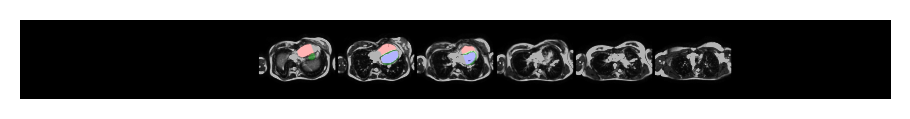

2020-12-21 10:46:25,599 INFO GT on AX


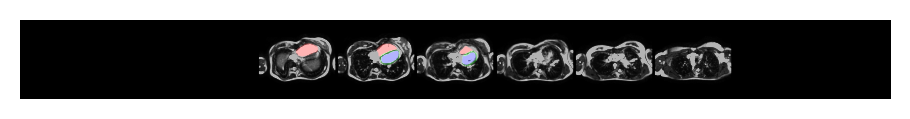

2020-12-21 10:46:26,111 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-21 10:46:26,118 INFO DICE LV: 0.8629382848739624
2020-12-21 10:46:26,126 INFO DICE RV: 0.8084356188774109
2020-12-21 10:46:26,134 INFO DICE MYO: 0.5763446092605591
2020-12-21 10:46:26,134 INFO m: [[ 0.5947 -0.7637  0.2512 -0.8047]
 [ 0.2834  0.4912  0.8237 -0.9624]
 [-0.7524 -0.4185  0.5083  4.227 ]]
2020-12-21 10:46:26,135 INFO m_mod: [[ 0.5947 -0.7637  0.2512  0.7783]
 [ 0.2834  0.4912  0.8237 -0.2227]
 [-0.7524 -0.4185  0.5083  0.9844]]
2020-12-21 10:46:26,135 INFO m_scaled: [[ 0.5947 -0.7637  0.2512  3.113 ]
 [ 0.2834  0.4912  0.8237 -0.8906]
 [-0.7524 -0.4185  0.5083  3.938 ]]
2020-12-21 10:46:26,137 INFO 0000-0HQQW4ZN_2007-05-23_ES_msk.nrrd
2020-12-21 10:46:30,688 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:46:30,894 INFO DICE LV: 0.8297159075737
2020-12-21 10:46:31,011 INFO DICE RV: 0.7516351342201233
2020-12-21 10:46:31,135 INFO DICE MYO: 0.6858285069465637
2020-12-21 10

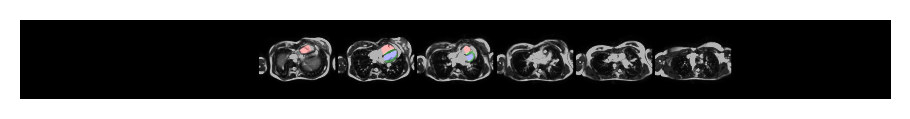

2020-12-21 10:46:32,132 INFO GT on AX


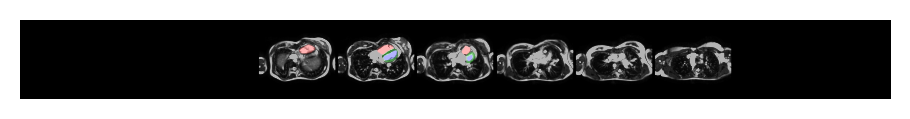

2020-12-21 10:46:32,668 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-21 10:46:32,675 INFO DICE LV: 0.8484811782836914
2020-12-21 10:46:32,682 INFO DICE RV: 0.7565573453903198
2020-12-21 10:46:32,689 INFO DICE MYO: 0.703204870223999
2020-12-21 10:46:32,689 INFO m: [[ 0.584  -0.78    0.2258 -0.8164]
 [ 0.2874  0.459   0.841  -0.967 ]
 [-0.7593 -0.4263  0.492   4.39  ]]
2020-12-21 10:46:32,690 INFO m_mod: [[ 0.584  -0.78    0.2258  0.809 ]
 [ 0.2874  0.459   0.841  -0.2305]
 [-0.7593 -0.4263  0.492   1.023 ]]
2020-12-21 10:46:32,690 INFO m_scaled: [[ 0.584  -0.78    0.2258  3.236 ]
 [ 0.2874  0.459   0.841  -0.922 ]
 [-0.7593 -0.4263  0.492   4.094 ]]
2020-12-21 10:46:32,691 INFO 0000-13JLP3HN_2007-05-22_ED_msk.nrrd
2020-12-21 10:46:37,307 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:46:37,511 INFO DICE LV: 0.9243648052215576
2020-12-21 10:46:37,671 INFO DICE RV: 0.8631919026374817
2020-12-21 10:46:37,839 INFO DICE MYO: 0.723622739315033
2020-12-21 1

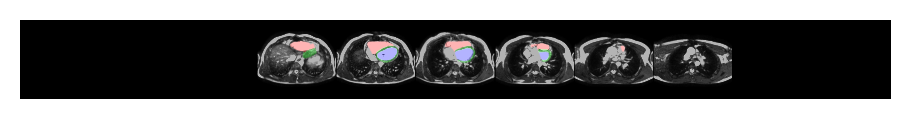

2020-12-21 10:46:38,845 INFO GT on AX


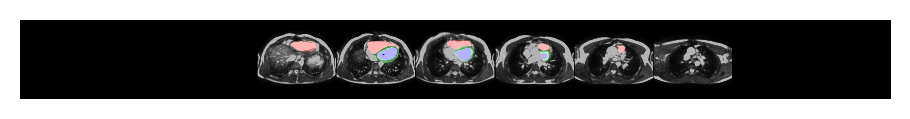

2020-12-21 10:46:39,419 INFO inv mask shape: (22, 352, 352, 4), gt mask shape: (22, 352, 352, 4)
2020-12-21 10:46:39,435 INFO DICE LV: 0.931624174118042
2020-12-21 10:46:39,447 INFO DICE RV: 0.871681809425354
2020-12-21 10:46:39,459 INFO DICE MYO: 0.738116979598999
2020-12-21 10:46:39,460 INFO m: [[ 0.5654 -0.805   0.1763 -0.8364]
 [ 0.2937  0.3967  0.8696 -0.9736]
 [-0.7705 -0.44    0.4607  4.688 ]]
2020-12-21 10:46:39,461 INFO m_mod: [[ 0.5654 -0.805   0.1763  0.8633]
 [ 0.2937  0.3967  0.8696 -0.2441]
 [-0.7705 -0.44    0.4607  1.092 ]]
2020-12-21 10:46:39,461 INFO m_scaled: [[ 0.5654 -0.805   0.1763  3.453 ]
 [ 0.2937  0.3967  0.8696 -0.9766]
 [-0.7705 -0.44    0.4607  4.367 ]]
2020-12-21 10:46:39,462 INFO 0000-13JLP3HN_2007-05-22_ES_msk.nrrd
2020-12-21 10:46:44,124 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:46:44,290 INFO DICE LV: 0.847737729549408
2020-12-21 10:46:44,400 INFO DICE RV: 0.6553118228912354
2020-12-21 10:46:44,496 INFO DICE MYO: 0.7143546938896179
2020-12-21 10:

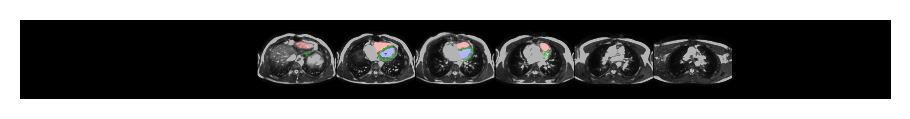

2020-12-21 10:46:45,490 INFO GT on AX


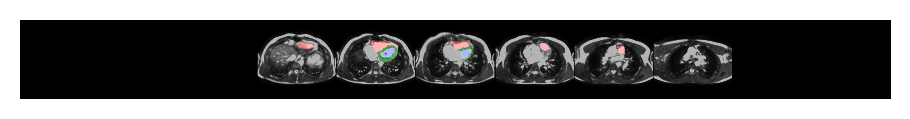

2020-12-21 10:46:46,072 INFO inv mask shape: (22, 352, 352, 4), gt mask shape: (22, 352, 352, 4)
2020-12-21 10:46:46,082 INFO DICE LV: 0.8647576570510864
2020-12-21 10:46:46,092 INFO DICE RV: 0.6557426452636719
2020-12-21 10:46:46,101 INFO DICE MYO: 0.729448676109314
2020-12-21 10:46:46,102 INFO m: [[ 0.571  -0.799   0.19   -0.8306]
 [ 0.292   0.4133  0.8623 -0.972 ]
 [-0.7676 -0.4368  0.4692  4.6   ]]
2020-12-21 10:46:46,103 INFO m_mod: [[ 0.571  -0.799   0.19    0.847 ]
 [ 0.292   0.4133  0.8623 -0.2397]
 [-0.7676 -0.4368  0.4692  1.071 ]]
2020-12-21 10:46:46,103 INFO m_scaled: [[ 0.571  -0.799   0.19    3.389 ]
 [ 0.292   0.4133  0.8623 -0.959 ]
 [-0.7676 -0.4368  0.4692  4.285 ]]
2020-12-21 10:46:46,105 INFO 0000-24YLF77L_2007-11-19_ED_msk.nrrd
2020-12-21 10:46:52,037 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:46:52,200 INFO DICE LV: 0.8946113586425781
2020-12-21 10:46:52,291 INFO DICE RV: 0.8364611864089966
2020-12-21 10:46:52,399 INFO DICE MYO: 0.6704845428466797
2020-12-21 

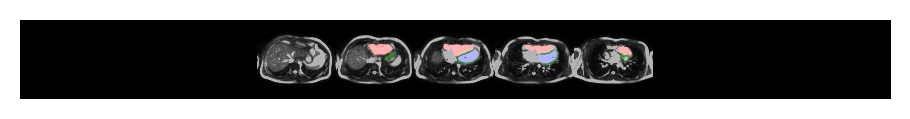

2020-12-21 10:46:53,387 INFO GT on AX


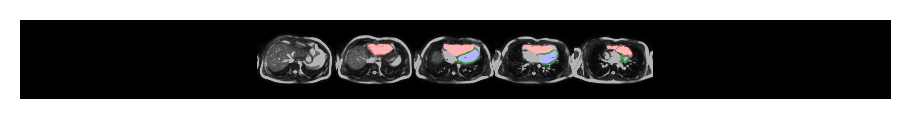

2020-12-21 10:46:53,869 INFO inv mask shape: (19, 256, 256, 4), gt mask shape: (19, 256, 256, 4)
2020-12-21 10:46:53,876 INFO DICE LV: 0.9031904935836792
2020-12-21 10:46:53,882 INFO DICE RV: 0.8471696376800537
2020-12-21 10:46:53,888 INFO DICE MYO: 0.6924825310707092
2020-12-21 10:46:53,889 INFO m: [[ 0.5713 -0.7983  0.1923 -0.83  ]
 [ 0.2917  0.4165  0.8613 -0.9717]
 [-0.767  -0.436   0.471   4.59  ]]
2020-12-21 10:46:53,889 INFO m_mod: [[ 0.5713 -0.7983  0.1923  0.8447]
 [ 0.2917  0.4165  0.8613 -0.2393]
 [-0.767  -0.436   0.471   1.068 ]]
2020-12-21 10:46:53,890 INFO m_scaled: [[ 0.5713 -0.7983  0.1923  3.379 ]
 [ 0.2917  0.4165  0.8613 -0.957 ]
 [-0.767  -0.436   0.471   4.273 ]]
2020-12-21 10:46:53,892 INFO 0000-24YLF77L_2007-11-19_ES_msk.nrrd
2020-12-21 10:46:58,704 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:46:58,843 INFO DICE LV: 0.8037616014480591
2020-12-21 10:46:58,927 INFO DICE RV: 0.6903946995735168
2020-12-21 10:46:59,013 INFO DICE MYO: 0.7003718614578247
2020-12-21

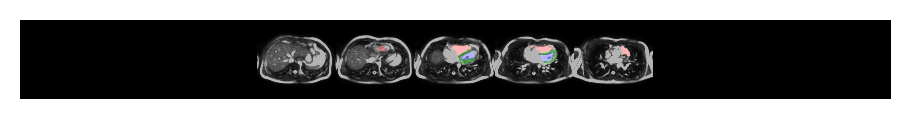

2020-12-21 10:46:59,990 INFO GT on AX


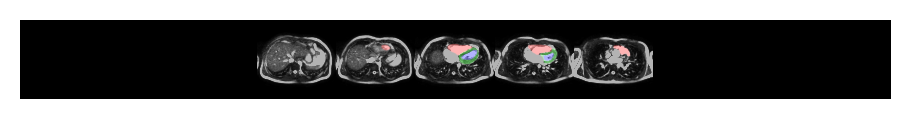

2020-12-21 10:47:00,476 INFO inv mask shape: (19, 256, 256, 4), gt mask shape: (19, 256, 256, 4)
2020-12-21 10:47:00,482 INFO DICE LV: 0.8162447214126587
2020-12-21 10:47:00,487 INFO DICE RV: 0.7036243677139282
2020-12-21 10:47:00,493 INFO DICE MYO: 0.7034983038902283
2020-12-21 10:47:00,494 INFO m: [[ 0.562  -0.8105  0.1658 -0.8403]
 [ 0.2952  0.3833  0.875  -0.975 ]
 [-0.773  -0.4429  0.4546  4.75  ]]
2020-12-21 10:47:00,494 INFO m_mod: [[ 0.562  -0.8105  0.1658  0.875 ]
 [ 0.2952  0.3833  0.875  -0.2466]
 [-0.773  -0.4429  0.4546  1.106 ]]
2020-12-21 10:47:00,495 INFO m_scaled: [[ 0.562  -0.8105  0.1658  3.5   ]
 [ 0.2952  0.3833  0.875  -0.9863]
 [-0.773  -0.4429  0.4546  4.426 ]]
2020-12-21 10:47:00,496 INFO 0000-2CVUG1C5_2006-09-06_ED_msk.nrrd
2020-12-21 10:47:05,106 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:05,244 INFO DICE LV: 0.6232755780220032
2020-12-21 10:47:05,329 INFO DICE RV: 0.2684200704097748
2020-12-21 10:47:05,412 INFO DICE MYO: 0.45574474334716797
2020-12-2

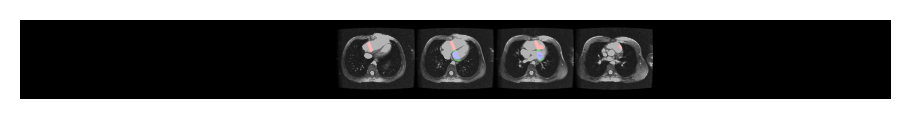

2020-12-21 10:47:06,430 INFO GT on AX


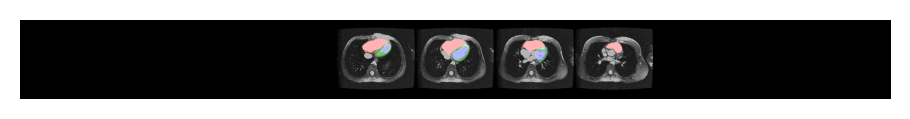

2020-12-21 10:47:06,970 INFO inv mask shape: (14, 512, 512, 4), gt mask shape: (14, 512, 512, 4)
2020-12-21 10:47:06,985 INFO DICE LV: 0.4561832547187805
2020-12-21 10:47:06,997 INFO DICE RV: 0.2805767357349396
2020-12-21 10:47:07,012 INFO DICE MYO: 0.30013975501060486
2020-12-21 10:47:07,012 INFO m: [[ 0.5996 -0.7563  0.2615 -0.799 ]
 [ 0.2817  0.5054  0.816  -0.9604]
 [-0.749  -0.4158  0.516   4.15  ]]
2020-12-21 10:47:07,013 INFO m_mod: [[ 0.5996 -0.7563  0.2615  0.764 ]
 [ 0.2817  0.5054  0.816  -0.2188]
 [-0.749  -0.4158  0.516   0.966 ]]
2020-12-21 10:47:07,013 INFO m_scaled: [[ 0.5996 -0.7563  0.2615  3.057 ]
 [ 0.2817  0.5054  0.816  -0.875 ]
 [-0.749  -0.4158  0.516   3.863 ]]
2020-12-21 10:47:07,014 INFO 0000-2CVUG1C5_2006-09-06_ES_msk.nrrd
2020-12-21 10:47:11,695 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:11,868 INFO DICE LV: 0.3903467059135437
2020-12-21 10:47:11,961 INFO DICE RV: 2.1451402062666602e-05
2020-12-21 10:47:12,066 INFO DICE MYO: 0.3333928883075714
2020-

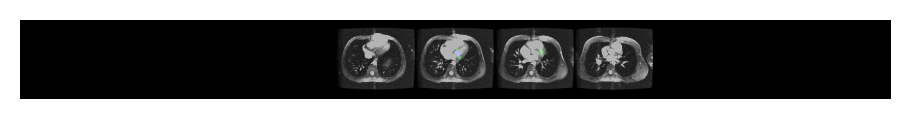

2020-12-21 10:47:12,937 INFO GT on AX


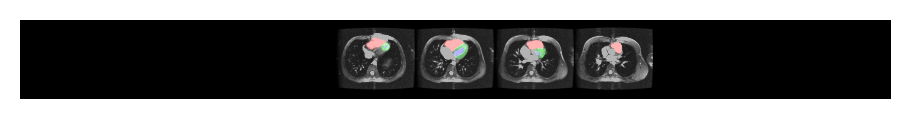

2020-12-21 10:47:13,475 INFO inv mask shape: (14, 512, 512, 4), gt mask shape: (14, 512, 512, 4)
2020-12-21 10:47:13,489 INFO DICE LV: 0.3635353446006775
2020-12-21 10:47:13,502 INFO DICE RV: 1.8824592189048417e-05
2020-12-21 10:47:13,516 INFO DICE MYO: 0.26875776052474976
2020-12-21 10:47:13,516 INFO m: [[ 0.592  -0.769   0.2424 -0.8076]
 [ 0.2847  0.4802  0.83   -0.964 ]
 [-0.7544 -0.4224  0.503   4.266 ]]
2020-12-21 10:47:13,517 INFO m_mod: [[ 0.592  -0.769   0.2424  0.7856]
 [ 0.2847  0.4802  0.83   -0.2241]
 [-0.7544 -0.4224  0.503   0.9937]]
2020-12-21 10:47:13,517 INFO m_scaled: [[ 0.592  -0.769   0.2424  3.143 ]
 [ 0.2847  0.4802  0.83   -0.8965]
 [-0.7544 -0.4224  0.503   3.975 ]]
2020-12-21 10:47:13,518 INFO 0000-2CW0G1A5_2006-04-06_ED_msk.nrrd
2020-12-21 10:47:18,199 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:18,342 INFO DICE LV: 0.9126222133636475
2020-12-21 10:47:18,425 INFO DICE RV: 0.8704587817192078
2020-12-21 10:47:18,508 INFO DICE MYO: 0.6743476390838623
2020-

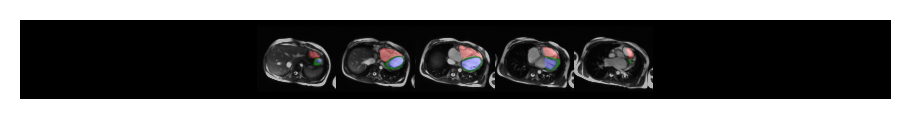

2020-12-21 10:47:19,494 INFO GT on AX


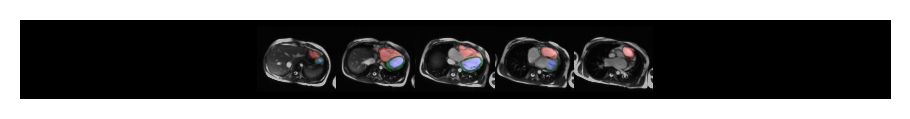

2020-12-21 10:47:19,968 INFO inv mask shape: (18, 156, 192, 4), gt mask shape: (18, 156, 192, 4)
2020-12-21 10:47:19,972 INFO DICE LV: 0.9222492575645447
2020-12-21 10:47:19,975 INFO DICE RV: 0.8695668578147888
2020-12-21 10:47:19,978 INFO DICE MYO: 0.692238986492157
2020-12-21 10:47:19,979 INFO m: [[ 0.6016 -0.753   0.266  -0.7964]
 [ 0.2808  0.511   0.812  -0.9595]
 [-0.7476 -0.414   0.519   4.117 ]]
2020-12-21 10:47:19,979 INFO m_mod: [[ 0.6016 -0.753   0.266   0.7583]
 [ 0.2808  0.511   0.812  -0.2173]
 [-0.7476 -0.414   0.519   0.959 ]]
2020-12-21 10:47:19,980 INFO m_scaled: [[ 0.6016 -0.753   0.266   3.033 ]
 [ 0.2808  0.511   0.812  -0.869 ]
 [-0.7476 -0.414   0.519   3.836 ]]
2020-12-21 10:47:19,981 INFO 0000-2CW0G1A5_2006-04-06_ES_msk.nrrd
2020-12-21 10:47:25,696 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:25,832 INFO DICE LV: 0.8943033814430237
2020-12-21 10:47:25,921 INFO DICE RV: 0.8062105774879456
2020-12-21 10:47:26,008 INFO DICE MYO: 0.7275757789611816
2020-12-21 

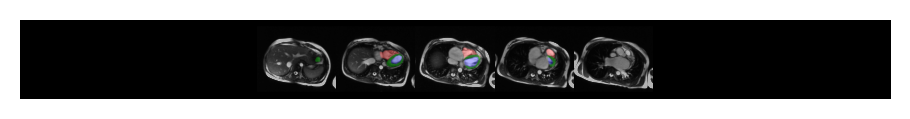

2020-12-21 10:47:26,981 INFO GT on AX


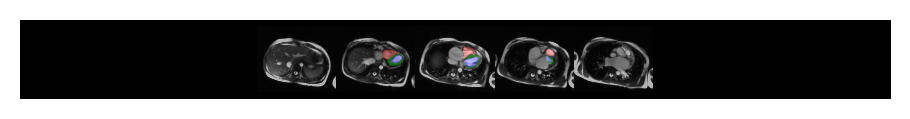

2020-12-21 10:47:27,440 INFO inv mask shape: (18, 156, 192, 4), gt mask shape: (18, 156, 192, 4)
2020-12-21 10:47:27,444 INFO DICE LV: 0.9060254693031311
2020-12-21 10:47:27,447 INFO DICE RV: 0.8137795925140381
2020-12-21 10:47:27,450 INFO DICE MYO: 0.7466903328895569
2020-12-21 10:47:27,450 INFO m: [[ 0.6055 -0.747   0.273  -0.7925]
 [ 0.2795  0.5205  0.806  -0.9575]
 [-0.745  -0.4119  0.5244  4.07  ]]
2020-12-21 10:47:27,451 INFO m_mod: [[ 0.6055 -0.747   0.273   0.7495]
 [ 0.2795  0.5205  0.806  -0.2153]
 [-0.745  -0.4119  0.5244  0.9473]]
2020-12-21 10:47:27,451 INFO m_scaled: [[ 0.6055 -0.747   0.273   2.998 ]
 [ 0.2795  0.5205  0.806  -0.8613]
 [-0.745  -0.4119  0.5244  3.79  ]]
2020-12-21 10:47:27,453 INFO 0000-2XRR719Z_2005-05-02_ED_msk.nrrd
2020-12-21 10:47:32,036 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:32,173 INFO DICE LV: 0.9198645353317261
2020-12-21 10:47:32,257 INFO DICE RV: 0.8411329984664917
2020-12-21 10:47:32,343 INFO DICE MYO: 0.6664956212043762
2020-12-21

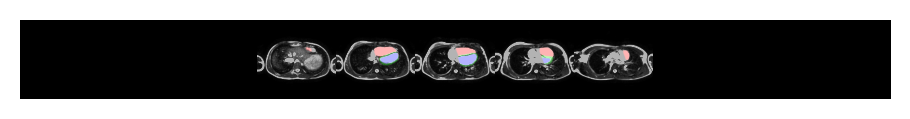

2020-12-21 10:47:33,318 INFO GT on AX


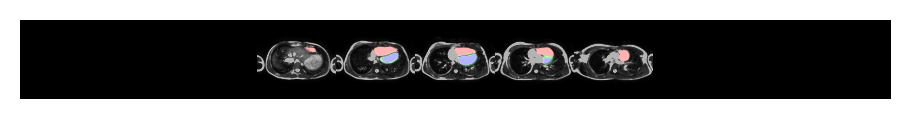

2020-12-21 10:47:33,798 INFO inv mask shape: (18, 256, 256, 4), gt mask shape: (18, 256, 256, 4)
2020-12-21 10:47:33,805 INFO DICE LV: 0.9343867301940918
2020-12-21 10:47:33,810 INFO DICE RV: 0.8417174220085144
2020-12-21 10:47:33,816 INFO DICE MYO: 0.6944344639778137
2020-12-21 10:47:33,816 INFO m: [[ 0.5947 -0.7646  0.25   -0.8047]
 [ 0.2834  0.4902  0.8247 -0.9624]
 [-0.7524 -0.4194  0.5083  4.227 ]]
2020-12-21 10:47:33,817 INFO m_mod: [[ 0.5947 -0.7646  0.25    0.7783]
 [ 0.2834  0.4902  0.8247 -0.2227]
 [-0.7524 -0.4194  0.5083  0.9844]]
2020-12-21 10:47:33,818 INFO m_scaled: [[ 0.5947 -0.7646  0.25    3.113 ]
 [ 0.2834  0.4902  0.8247 -0.8906]
 [-0.7524 -0.4194  0.5083  3.938 ]]
2020-12-21 10:47:33,819 INFO 0000-2XRR719Z_2005-05-02_ES_msk.nrrd
2020-12-21 10:47:39,388 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:39,522 INFO DICE LV: 0.8566523194313049
2020-12-21 10:47:39,606 INFO DICE RV: 0.7614309191703796
2020-12-21 10:47:39,690 INFO DICE MYO: 0.7188416719436646
2020-12-21

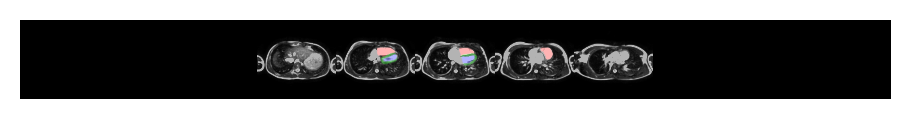

2020-12-21 10:47:40,662 INFO GT on AX


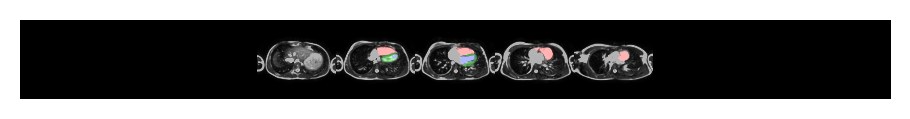

2020-12-21 10:47:41,146 INFO inv mask shape: (18, 256, 256, 4), gt mask shape: (18, 256, 256, 4)
2020-12-21 10:47:41,151 INFO DICE LV: 0.8761368989944458
2020-12-21 10:47:41,157 INFO DICE RV: 0.7678642272949219
2020-12-21 10:47:41,162 INFO DICE MYO: 0.7539111375808716
2020-12-21 10:47:41,162 INFO m: [[ 0.588  -0.7744  0.234  -0.812 ]
 [ 0.286   0.4695  0.8354 -0.9653]
 [-0.757  -0.4243  0.4973  4.324 ]]
2020-12-21 10:47:41,163 INFO m_mod: [[ 0.588  -0.7744  0.234   0.7964]
 [ 0.286   0.4695  0.8354 -0.227 ]
 [-0.757  -0.4243  0.4973  1.007 ]]
2020-12-21 10:47:41,164 INFO m_scaled: [[ 0.588  -0.7744  0.234   3.186 ]
 [ 0.286   0.4695  0.8354 -0.908 ]
 [-0.757  -0.4243  0.4973  4.027 ]]
2020-12-21 10:47:41,165 INFO 0000-3EX293QC_2006-06-19_ED_msk.nrrd
2020-12-21 10:47:46,750 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:46,889 INFO DICE LV: 0.9133521318435669
2020-12-21 10:47:46,978 INFO DICE RV: 0.8722716569900513
2020-12-21 10:47:47,066 INFO DICE MYO: 0.717027485370636
2020-12-21 

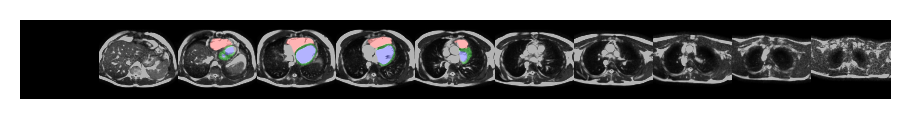

2020-12-21 10:47:48,043 INFO GT on AX


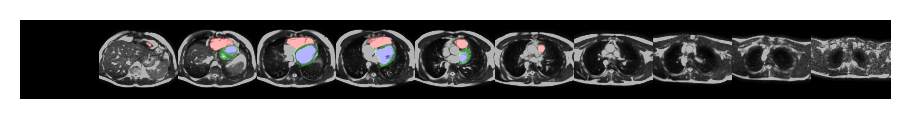

2020-12-21 10:47:48,581 INFO inv mask shape: (38, 256, 256, 4), gt mask shape: (38, 256, 256, 4)
2020-12-21 10:47:48,592 INFO DICE LV: 0.9226452708244324
2020-12-21 10:47:48,602 INFO DICE RV: 0.8740137219429016
2020-12-21 10:47:48,613 INFO DICE MYO: 0.73433917760849
2020-12-21 10:47:48,614 INFO m: [[ 0.584  -0.779   0.227  -0.816 ]
 [ 0.2869  0.4604  0.84   -0.967 ]
 [-0.759  -0.4255  0.4927  4.383 ]]
2020-12-21 10:47:48,615 INFO m_mod: [[ 0.584  -0.779   0.227   0.8076]
 [ 0.2869  0.4604  0.84   -0.2305]
 [-0.759  -0.4255  0.4927  1.021 ]]
2020-12-21 10:47:48,615 INFO m_scaled: [[ 0.584  -0.779   0.227   3.23  ]
 [ 0.2869  0.4604  0.84   -0.922 ]
 [-0.759  -0.4255  0.4927  4.086 ]]
2020-12-21 10:47:48,617 INFO 0000-3EX293QC_2006-06-19_ES_msk.nrrd
2020-12-21 10:47:53,238 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:53,377 INFO DICE LV: 0.8439686298370361
2020-12-21 10:47:53,468 INFO DICE RV: 0.7588600516319275
2020-12-21 10:47:53,556 INFO DICE MYO: 0.6915400624275208
2020-12-21 1

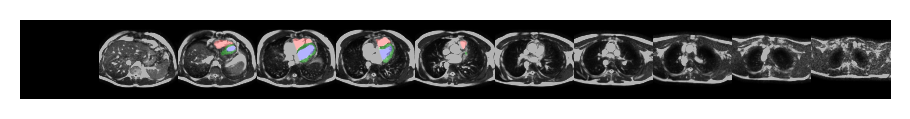

2020-12-21 10:47:54,576 INFO GT on AX


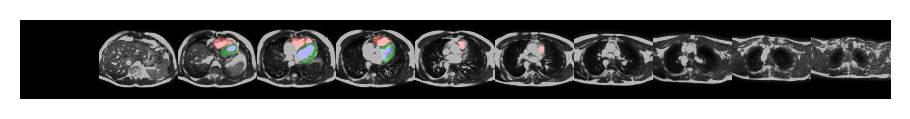

2020-12-21 10:47:55,165 INFO inv mask shape: (38, 256, 256, 4), gt mask shape: (38, 256, 256, 4)
2020-12-21 10:47:55,177 INFO DICE LV: 0.8796942234039307
2020-12-21 10:47:55,188 INFO DICE RV: 0.7655227780342102
2020-12-21 10:47:55,199 INFO DICE MYO: 0.7236571907997131
2020-12-21 10:47:55,200 INFO m: [[ 0.586  -0.7773  0.2303 -0.8145]
 [ 0.2866  0.464   0.8384 -0.9663]
 [-0.7583 -0.4253  0.4946  4.363 ]]
2020-12-21 10:47:55,201 INFO m_mod: [[ 0.586  -0.7773  0.2303  0.803 ]
 [ 0.2866  0.464   0.8384 -0.2295]
 [-0.7583 -0.4253  0.4946  1.017 ]]
2020-12-21 10:47:55,202 INFO m_scaled: [[ 0.586  -0.7773  0.2303  3.213 ]
 [ 0.2866  0.464   0.8384 -0.918 ]
 [-0.7583 -0.4253  0.4946  4.066 ]]
2020-12-21 10:47:55,203 INFO 0000-5RMHZGWP_2006-08-03_ED_msk.nrrd
2020-12-21 10:47:59,728 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:47:59,866 INFO DICE LV: 0.8857872486114502
2020-12-21 10:47:59,956 INFO DICE RV: 0.8120139837265015
2020-12-21 10:48:00,045 INFO DICE MYO: 0.6583057641983032
2020-12-21

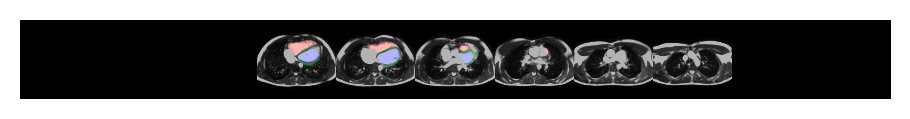

2020-12-21 10:48:01,079 INFO GT on AX


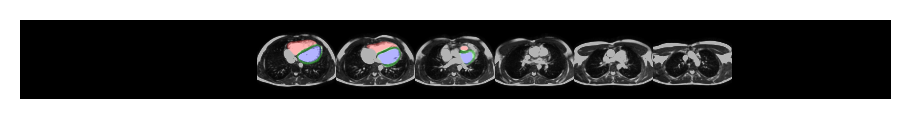

2020-12-21 10:48:01,655 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-21 10:48:01,662 INFO DICE LV: 0.88908451795578
2020-12-21 10:48:01,670 INFO DICE RV: 0.8255643844604492
2020-12-21 10:48:01,677 INFO DICE MYO: 0.6857099533081055
2020-12-21 10:48:01,678 INFO m: [[ 0.5815 -0.784   0.217  -0.8193]
 [ 0.2883  0.4482  0.846  -0.9683]
 [-0.7607 -0.4294  0.4868  4.43  ]]
2020-12-21 10:48:01,678 INFO m_mod: [[ 0.5815 -0.784   0.217   0.816 ]
 [ 0.2883  0.4482  0.846  -0.2319]
 [-0.7607 -0.4294  0.4868  1.032 ]]
2020-12-21 10:48:01,679 INFO m_scaled: [[ 0.5815 -0.784   0.217   3.264 ]
 [ 0.2883  0.4482  0.846  -0.9277]
 [-0.7607 -0.4294  0.4868  4.13  ]]
2020-12-21 10:48:01,681 INFO 0000-5RMHZGWP_2006-08-03_ES_msk.nrrd
2020-12-21 10:48:06,323 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:48:06,470 INFO DICE LV: 0.8546109795570374
2020-12-21 10:48:06,557 INFO DICE RV: 0.7693017721176147
2020-12-21 10:48:06,646 INFO DICE MYO: 0.6680670976638794
2020-12-21 1

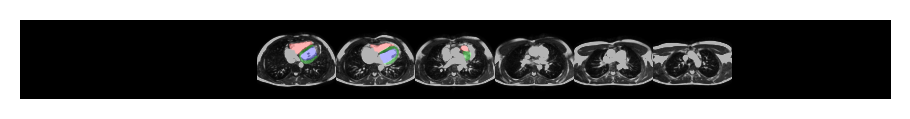

2020-12-21 10:48:07,683 INFO GT on AX


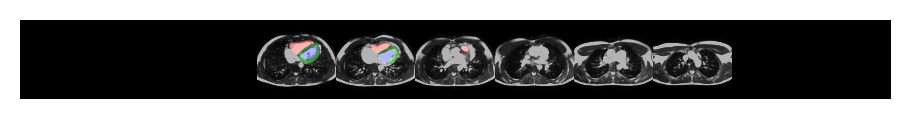

2020-12-21 10:48:08,264 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-21 10:48:08,272 INFO DICE LV: 0.8606633543968201
2020-12-21 10:48:08,279 INFO DICE RV: 0.8070046901702881
2020-12-21 10:48:08,287 INFO DICE MYO: 0.6748865246772766
2020-12-21 10:48:08,287 INFO m: [[ 0.578  -0.7886  0.2095 -0.8223]
 [ 0.2893  0.4385  0.8506 -0.969 ]
 [-0.7627 -0.4312  0.4814  4.473 ]]
2020-12-21 10:48:08,288 INFO m_mod: [[ 0.578  -0.7886  0.2095  0.8237]
 [ 0.2893  0.4385  0.8506 -0.2339]
 [-0.7627 -0.4312  0.4814  1.042 ]]
2020-12-21 10:48:08,288 INFO m_scaled: [[ 0.578  -0.7886  0.2095  3.295 ]
 [ 0.2893  0.4385  0.8506 -0.9355]
 [-0.7627 -0.4312  0.4814  4.168 ]]
2020-12-21 10:48:08,290 INFO 0000-5W8RFCJD_2005-04-18_ED_msk.nrrd
2020-12-21 10:48:14,228 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:48:14,355 INFO DICE LV: 0.7136306166648865
2020-12-21 10:48:14,431 INFO DICE RV: 0.520254909992218
2020-12-21 10:48:14,506 INFO DICE MYO: 0.3867625892162323
2020-12-21 

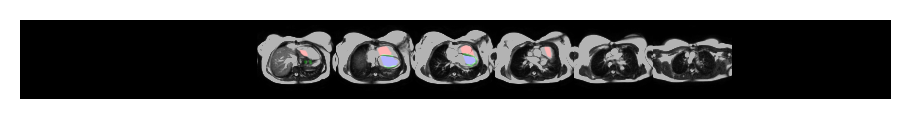

2020-12-21 10:48:15,480 INFO GT on AX


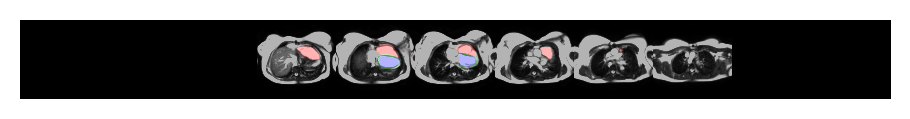

2020-12-21 10:48:15,964 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-21 10:48:15,969 INFO DICE LV: 0.7371693849563599
2020-12-21 10:48:15,974 INFO DICE RV: 0.5647181868553162
2020-12-21 10:48:15,978 INFO DICE MYO: 0.42563101649284363
2020-12-21 10:48:15,979 INFO m: [[ 0.586  -0.7773  0.2306 -0.814 ]
 [ 0.2866  0.4646  0.838  -0.9663]
 [-0.7583 -0.4248  0.4949  4.36  ]]
2020-12-21 10:48:15,980 INFO m_mod: [[ 0.586  -0.7773  0.2306  0.8027]
 [ 0.2866  0.4646  0.838  -0.229 ]
 [-0.7583 -0.4248  0.4949  1.016 ]]
2020-12-21 10:48:15,981 INFO m_scaled: [[ 0.586  -0.7773  0.2306  3.21  ]
 [ 0.2866  0.4646  0.838  -0.916 ]
 [-0.7583 -0.4248  0.4949  4.062 ]]
2020-12-21 10:48:15,982 INFO 0000-5W8RFCJD_2005-04-18_ES_msk.nrrd
2020-12-21 10:48:20,590 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:48:20,722 INFO DICE LV: 0.4589349627494812
2020-12-21 10:48:20,805 INFO DICE RV: 0.19771882891654968
2020-12-21 10:48:20,888 INFO DICE MYO: 0.2821069061756134
2020-12-

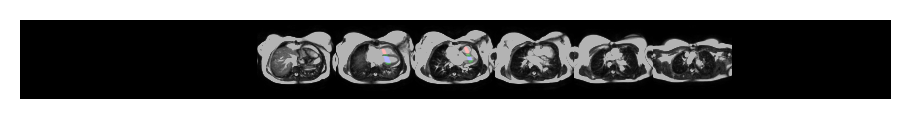

2020-12-21 10:48:21,885 INFO GT on AX


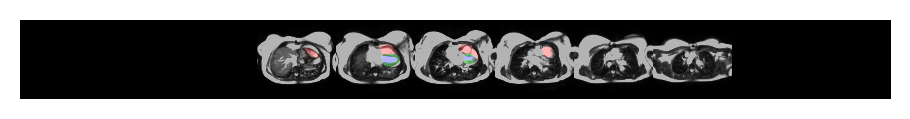

2020-12-21 10:48:22,384 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-21 10:48:22,389 INFO DICE LV: 0.46638765931129456
2020-12-21 10:48:22,394 INFO DICE RV: 0.18586938083171844
2020-12-21 10:48:22,399 INFO DICE MYO: 0.285678893327713
2020-12-21 10:48:22,400 INFO m: [[ 0.592  -0.767   0.2455 -0.807 ]
 [ 0.2842  0.4841  0.8276 -0.964 ]
 [-0.754  -0.4202  0.505   4.266 ]]
2020-12-21 10:48:22,400 INFO m_mod: [[ 0.592  -0.767   0.2455  0.7856]
 [ 0.2842  0.4841  0.8276 -0.2246]
 [-0.754  -0.4202  0.505   0.994 ]]
2020-12-21 10:48:22,401 INFO m_scaled: [[ 0.592  -0.767   0.2455  3.143 ]
 [ 0.2842  0.4841  0.8276 -0.8984]
 [-0.754  -0.4202  0.505   3.977 ]]
2020-12-21 10:48:22,402 INFO 0000-DLTVKE94_2006-07-18_ED_msk.nrrd
2020-12-21 10:48:28,088 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:48:28,223 INFO DICE LV: 0.9120926856994629
2020-12-21 10:48:28,308 INFO DICE RV: 0.8434829115867615
2020-12-21 10:48:28,393 INFO DICE MYO: 0.6529549956321716
2020-12-2

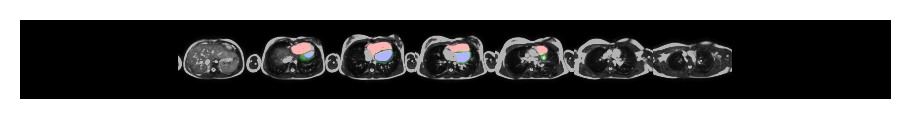

2020-12-21 10:48:29,405 INFO GT on AX


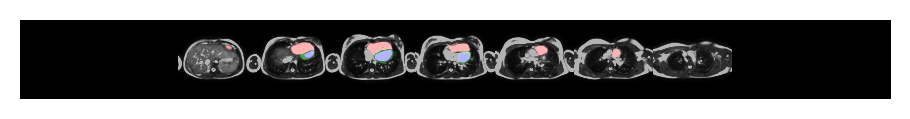

2020-12-21 10:48:29,922 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-21 10:48:29,930 INFO DICE LV: 0.9157152771949768
2020-12-21 10:48:29,939 INFO DICE RV: 0.8474856615066528
2020-12-21 10:48:29,947 INFO DICE MYO: 0.6649687886238098
2020-12-21 10:48:29,948 INFO m: [[ 0.586  -0.778   0.2301 -0.814 ]
 [ 0.2866  0.4639  0.839  -0.9663]
 [-0.7583 -0.4255  0.4946  4.355 ]]
2020-12-21 10:48:29,948 INFO m_mod: [[ 0.586  -0.778   0.2301  0.8022]
 [ 0.2866  0.4639  0.839  -0.229 ]
 [-0.7583 -0.4255  0.4946  1.015 ]]
2020-12-21 10:48:29,949 INFO m_scaled: [[ 0.586  -0.778   0.2301  3.209 ]
 [ 0.2866  0.4639  0.839  -0.916 ]
 [-0.7583 -0.4255  0.4946  4.06  ]]
2020-12-21 10:48:29,950 INFO 0000-DLTVKE94_2006-07-18_ES_msk.nrrd
2020-12-21 10:48:34,661 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:48:34,816 INFO DICE LV: 0.7610305547714233
2020-12-21 10:48:34,906 INFO DICE RV: 0.662214994430542
2020-12-21 10:48:34,993 INFO DICE MYO: 0.662229597568512
2020-12-21 1

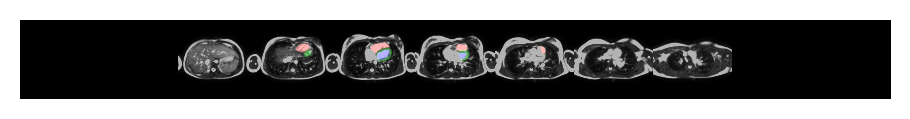

2020-12-21 10:48:35,993 INFO GT on AX


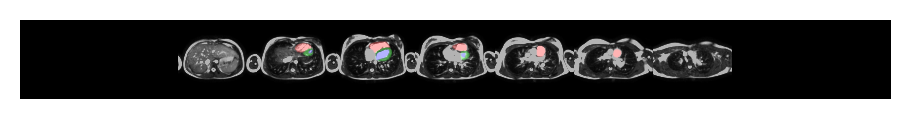

2020-12-21 10:48:36,511 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-21 10:48:36,520 INFO DICE LV: 0.7697429060935974
2020-12-21 10:48:36,527 INFO DICE RV: 0.6693296432495117
2020-12-21 10:48:36,534 INFO DICE MYO: 0.6764426827430725
2020-12-21 10:48:36,535 INFO m: [[ 0.5713 -0.797   0.1937 -0.8296]
 [ 0.2915  0.4182  0.86   -0.9717]
 [-0.767  -0.435   0.4714  4.58  ]]
2020-12-21 10:48:36,535 INFO m_mod: [[ 0.5713 -0.797   0.1937  0.8433]
 [ 0.2915  0.4182  0.86   -0.2393]
 [-0.767  -0.435   0.4714  1.066 ]]
2020-12-21 10:48:36,536 INFO m_scaled: [[ 0.5713 -0.797   0.1937  3.373 ]
 [ 0.2915  0.4182  0.86   -0.957 ]
 [-0.767  -0.435   0.4714  4.266 ]]
2020-12-21 10:48:36,537 INFO 0000-E0RJZQQM_2005-09-30_ED_msk.nrrd
2020-12-21 10:48:41,169 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:48:41,311 INFO DICE LV: 0.9027633666992188
2020-12-21 10:48:41,418 INFO DICE RV: 0.7971005439758301
2020-12-21 10:48:41,509 INFO DICE MYO: 0.630345344543457
2020-12-21 

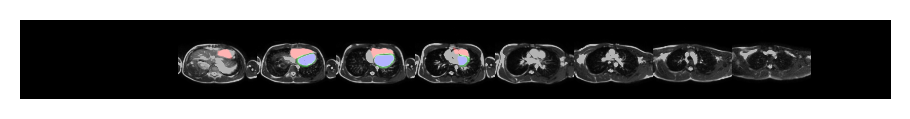

2020-12-21 10:48:42,518 INFO GT on AX


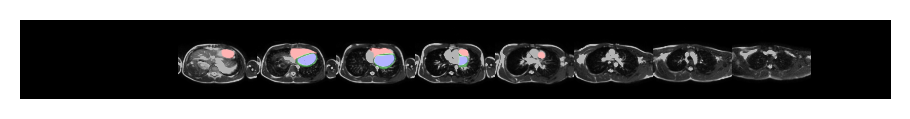

2020-12-21 10:48:43,049 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-21 10:48:43,055 INFO DICE LV: 0.9235436320304871
2020-12-21 10:48:43,061 INFO DICE RV: 0.8182650208473206
2020-12-21 10:48:43,068 INFO DICE MYO: 0.6826880574226379
2020-12-21 10:48:43,069 INFO m: [[ 0.584  -0.78    0.2252 -0.816 ]
 [ 0.2874  0.4585  0.8413 -0.967 ]
 [-0.759  -0.4265  0.4917  4.387 ]]
2020-12-21 10:48:43,069 INFO m_mod: [[ 0.584  -0.78    0.2252  0.808 ]
 [ 0.2874  0.4585  0.8413 -0.2305]
 [-0.759  -0.4265  0.4917  1.022 ]]
2020-12-21 10:48:43,070 INFO m_scaled: [[ 0.584  -0.78    0.2252  3.232 ]
 [ 0.2874  0.4585  0.8413 -0.922 ]
 [-0.759  -0.4265  0.4917  4.09  ]]
2020-12-21 10:48:43,071 INFO 0000-E0RJZQQM_2005-09-30_ES_msk.nrrd
2020-12-21 10:48:47,671 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:48:47,895 INFO DICE LV: 0.8157740831375122
2020-12-21 10:48:47,988 INFO DICE RV: 0.5974756479263306
2020-12-21 10:48:48,075 INFO DICE MYO: 0.6430249214172363
2020-12-21

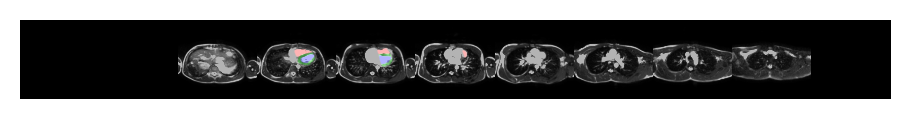

2020-12-21 10:48:49,050 INFO GT on AX


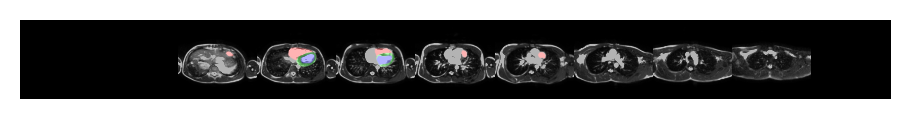

2020-12-21 10:48:49,558 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-21 10:48:49,565 INFO DICE LV: 0.8546398282051086
2020-12-21 10:48:49,572 INFO DICE RV: 0.6158459186553955
2020-12-21 10:48:49,579 INFO DICE MYO: 0.6645771861076355
2020-12-21 10:48:49,580 INFO m: [[ 0.584  -0.7793  0.2262 -0.816 ]
 [ 0.2869  0.4592  0.841  -0.967 ]
 [-0.759  -0.4263  0.492   4.383 ]]
2020-12-21 10:48:49,580 INFO m_mod: [[ 0.584  -0.7793  0.2262  0.807 ]
 [ 0.2869  0.4592  0.841  -0.23  ]
 [-0.759  -0.4263  0.492   1.021 ]]
2020-12-21 10:48:49,581 INFO m_scaled: [[ 0.584  -0.7793  0.2262  3.229 ]
 [ 0.2869  0.4592  0.841  -0.92  ]
 [-0.759  -0.4263  0.492   4.086 ]]
2020-12-21 10:48:49,582 INFO 0000-E24LRCWD_2006-11-23_ED_msk.nrrd
2020-12-21 10:48:54,181 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:48:54,321 INFO DICE LV: 0.8812990784645081
2020-12-21 10:48:54,408 INFO DICE RV: 0.8029913902282715
2020-12-21 10:48:54,496 INFO DICE MYO: 0.6489071846008301
2020-12-21

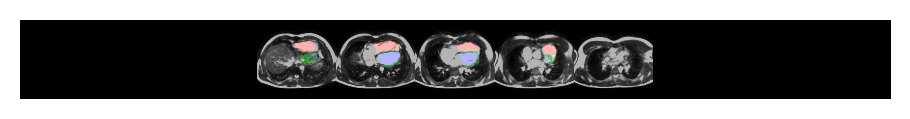

2020-12-21 10:48:55,485 INFO GT on AX


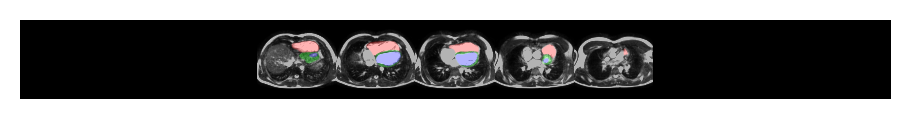

2020-12-21 10:48:55,967 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-21 10:48:55,974 INFO DICE LV: 0.8853006958961487
2020-12-21 10:48:55,979 INFO DICE RV: 0.7921729683876038
2020-12-21 10:48:55,984 INFO DICE MYO: 0.655127763748169
2020-12-21 10:48:55,985 INFO m: [[ 0.568  -0.8022  0.1829 -0.8335]
 [ 0.293   0.4048  0.866  -0.973 ]
 [-0.769  -0.4385  0.465   4.645 ]]
2020-12-21 10:48:55,986 INFO m_mod: [[ 0.568  -0.8022  0.1829  0.8555]
 [ 0.293   0.4048  0.866  -0.2417]
 [-0.769  -0.4385  0.465   1.082 ]]
2020-12-21 10:48:55,986 INFO m_scaled: [[ 0.568  -0.8022  0.1829  3.422 ]
 [ 0.293   0.4048  0.866  -0.967 ]
 [-0.769  -0.4385  0.465   4.33  ]]
2020-12-21 10:48:55,987 INFO 0000-E24LRCWD_2006-11-23_ES_msk.nrrd
2020-12-21 10:49:00,602 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:00,742 INFO DICE LV: 0.856271505355835
2020-12-21 10:49:00,830 INFO DICE RV: 0.7332161068916321
2020-12-21 10:49:00,917 INFO DICE MYO: 0.6221452355384827
2020-12-21 1

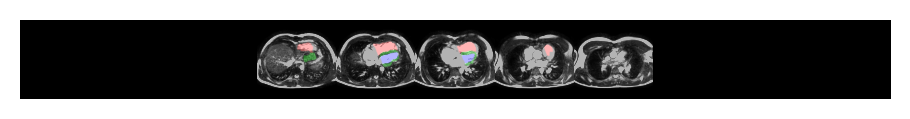

2020-12-21 10:49:01,896 INFO GT on AX


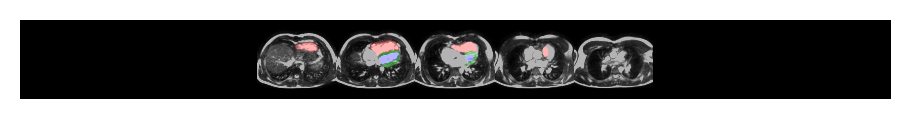

2020-12-21 10:49:02,382 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-21 10:49:02,388 INFO DICE LV: 0.859010636806488
2020-12-21 10:49:02,393 INFO DICE RV: 0.7483277916908264
2020-12-21 10:49:02,399 INFO DICE MYO: 0.6388431191444397
2020-12-21 10:49:02,399 INFO m: [[ 0.5737 -0.795   0.198  -0.8276]
 [ 0.2908  0.4238  0.858  -0.971 ]
 [-0.7656 -0.4346  0.474   4.55  ]]
2020-12-21 10:49:02,400 INFO m_mod: [[ 0.5737 -0.795   0.198   0.8384]
 [ 0.2908  0.4238  0.858  -0.2378]
 [-0.7656 -0.4346  0.474   1.061 ]]
2020-12-21 10:49:02,401 INFO m_scaled: [[ 0.5737 -0.795   0.198   3.354 ]
 [ 0.2908  0.4238  0.858  -0.951 ]
 [-0.7656 -0.4346  0.474   4.242 ]]
2020-12-21 10:49:02,401 INFO 0000-FANDNZ55_2007-02-19_ED_msk.nrrd
2020-12-21 10:49:06,976 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:07,117 INFO DICE LV: 0.9323225021362305
2020-12-21 10:49:07,219 INFO DICE RV: 0.8799083828926086
2020-12-21 10:49:07,307 INFO DICE MYO: 0.710231363773346
2020-12-21 1

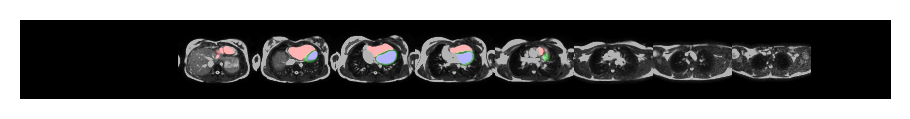

2020-12-21 10:49:08,327 INFO GT on AX


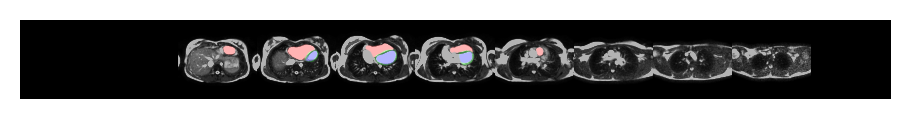

2020-12-21 10:49:08,939 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-21 10:49:08,948 INFO DICE LV: 0.939832329750061
2020-12-21 10:49:08,957 INFO DICE RV: 0.8867678046226501
2020-12-21 10:49:08,966 INFO DICE MYO: 0.7271897196769714
2020-12-21 10:49:08,967 INFO m: [[ 0.5723 -0.796   0.1973 -0.829 ]
 [ 0.2913  0.422   0.859  -0.971 ]
 [-0.7666 -0.4338  0.4734  4.574 ]]
2020-12-21 10:49:08,968 INFO m_mod: [[ 0.5723 -0.796   0.1973  0.843 ]
 [ 0.2913  0.422   0.859  -0.2393]
 [-0.7666 -0.4338  0.4734  1.067 ]]
2020-12-21 10:49:08,968 INFO m_scaled: [[ 0.5723 -0.796   0.1973  3.371 ]
 [ 0.2913  0.422   0.859  -0.957 ]
 [-0.7666 -0.4338  0.4734  4.27  ]]
2020-12-21 10:49:08,969 INFO 0000-FANDNZ55_2007-02-19_ES_msk.nrrd
2020-12-21 10:49:13,624 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:13,792 INFO DICE LV: 0.8650516867637634
2020-12-21 10:49:13,968 INFO DICE RV: 0.8039188981056213
2020-12-21 10:49:14,060 INFO DICE MYO: 0.7546650767326355
2020-12-21 

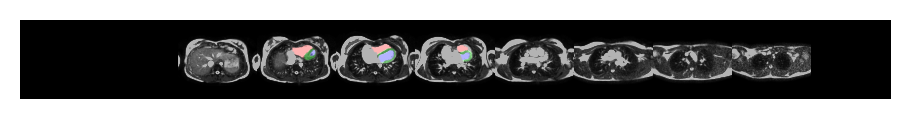

2020-12-21 10:49:15,068 INFO GT on AX


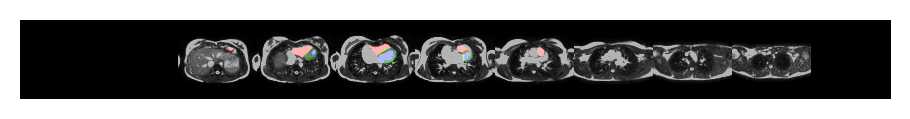

2020-12-21 10:49:15,695 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-21 10:49:15,705 INFO DICE LV: 0.8722407221794128
2020-12-21 10:49:15,713 INFO DICE RV: 0.8112410306930542
2020-12-21 10:49:15,721 INFO DICE MYO: 0.7797573804855347
2020-12-21 10:49:15,722 INFO m: [[ 0.5664 -0.804   0.1794 -0.8354]
 [ 0.2935  0.4004  0.8677 -0.9736]
 [-0.77   -0.439   0.4631  4.676 ]]
2020-12-21 10:49:15,722 INFO m_mod: [[ 0.5664 -0.804   0.1794  0.8613]
 [ 0.2935  0.4004  0.8677 -0.2437]
 [-0.77   -0.439   0.4631  1.091 ]]
2020-12-21 10:49:15,723 INFO m_scaled: [[ 0.5664 -0.804   0.1794  3.445 ]
 [ 0.2935  0.4004  0.8677 -0.9746]
 [-0.77   -0.439   0.4631  4.363 ]]
2020-12-21 10:49:15,724 INFO 0000-FHQU30DQ_2005-05-10_ED_msk.nrrd
2020-12-21 10:49:20,385 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:20,564 INFO DICE LV: 0.8056511878967285
2020-12-21 10:49:20,724 INFO DICE RV: 0.6756494045257568
2020-12-21 10:49:20,819 INFO DICE MYO: 0.5239574909210205
2020-12-21

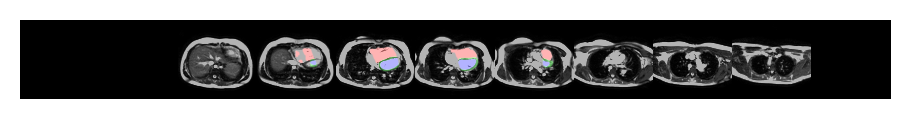

2020-12-21 10:49:21,842 INFO GT on AX


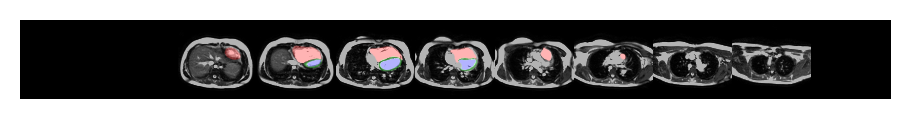

2020-12-21 10:49:22,440 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-21 10:49:22,448 INFO DICE LV: 0.8255372643470764
2020-12-21 10:49:22,456 INFO DICE RV: 0.6756488680839539
2020-12-21 10:49:22,464 INFO DICE MYO: 0.5547143220901489
2020-12-21 10:49:22,464 INFO m: [[ 0.5913 -0.7695  0.2405 -0.808 ]
 [ 0.2847  0.4785  0.8306 -0.964 ]
 [-0.7544 -0.4226  0.502   4.273 ]]
2020-12-21 10:49:22,465 INFO m_mod: [[ 0.5913 -0.7695  0.2405  0.7866]
 [ 0.2847  0.4785  0.8306 -0.2246]
 [-0.7544 -0.4226  0.502   0.995 ]]
2020-12-21 10:49:22,466 INFO m_scaled: [[ 0.5913 -0.7695  0.2405  3.146 ]
 [ 0.2847  0.4785  0.8306 -0.8984]
 [-0.7544 -0.4226  0.502   3.98  ]]
2020-12-21 10:49:22,467 INFO 0000-FHQU30DQ_2005-05-10_ES_msk.nrrd
2020-12-21 10:49:27,107 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:27,274 INFO DICE LV: 0.7107893228530884
2020-12-21 10:49:27,413 INFO DICE RV: 0.5120754837989807
2020-12-21 10:49:27,514 INFO DICE MYO: 0.5630525350570679
2020-12-21

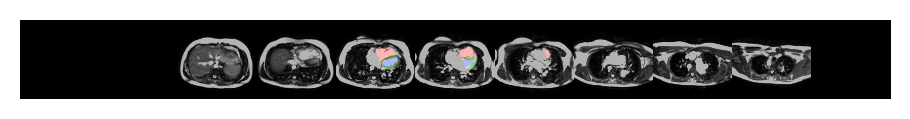

2020-12-21 10:49:28,530 INFO GT on AX


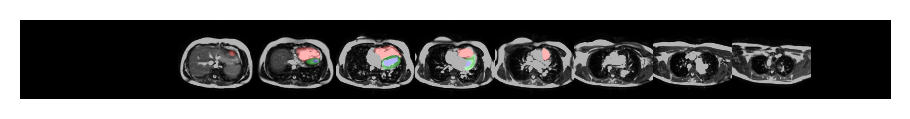

2020-12-21 10:49:29,149 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-21 10:49:29,158 INFO DICE LV: 0.7021904587745667
2020-12-21 10:49:29,168 INFO DICE RV: 0.491813987493515
2020-12-21 10:49:29,177 INFO DICE MYO: 0.57381671667099
2020-12-21 10:49:29,178 INFO m: [[ 0.5967 -0.761   0.2532 -0.8022]
 [ 0.2825  0.4946  0.822  -0.9614]
 [-0.751  -0.4187  0.5103  4.195 ]]
2020-12-21 10:49:29,178 INFO m_mod: [[ 0.5967 -0.761   0.2532  0.772 ]
 [ 0.2825  0.4946  0.822  -0.2212]
 [-0.751  -0.4187  0.5103  0.976 ]]
2020-12-21 10:49:29,179 INFO m_scaled: [[ 0.5967 -0.761   0.2532  3.088 ]
 [ 0.2825  0.4946  0.822  -0.885 ]
 [-0.751  -0.4187  0.5103  3.904 ]]
2020-12-21 10:49:29,180 INFO 0000-G8XJ03CH_2007-10-31_ED_msk.nrrd
2020-12-21 10:49:36,256 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:36,385 INFO DICE LV: 0.9008288979530334
2020-12-21 10:49:36,464 INFO DICE RV: 0.7708814740180969
2020-12-21 10:49:36,542 INFO DICE MYO: 0.6529620885848999
2020-12-21 10

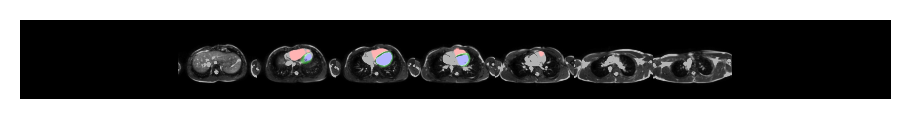

2020-12-21 10:49:37,539 INFO GT on AX


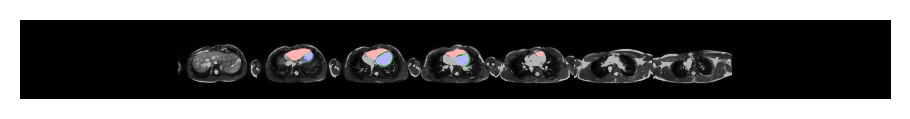

2020-12-21 10:49:38,049 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-21 10:49:38,057 INFO DICE LV: 0.9150161743164062
2020-12-21 10:49:38,066 INFO DICE RV: 0.759799063205719
2020-12-21 10:49:38,074 INFO DICE MYO: 0.6759119033813477
2020-12-21 10:49:38,075 INFO m: [[ 0.5977 -0.76    0.2554 -0.802 ]
 [ 0.2827  0.4976  0.82   -0.9614]
 [-0.7505 -0.4177  0.512   4.184 ]]
2020-12-21 10:49:38,076 INFO m_mod: [[ 0.5977 -0.76    0.2554  0.7705]
 [ 0.2827  0.4976  0.82   -0.2207]
 [-0.7505 -0.4177  0.512   0.9746]]
2020-12-21 10:49:38,076 INFO m_scaled: [[ 0.5977 -0.76    0.2554  3.082 ]
 [ 0.2827  0.4976  0.82   -0.883 ]
 [-0.7505 -0.4177  0.512   3.898 ]]
2020-12-21 10:49:38,078 INFO 0000-G8XJ03CH_2007-10-31_ES_msk.nrrd
2020-12-21 10:49:42,740 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:42,884 INFO DICE LV: 0.8178808093070984
2020-12-21 10:49:42,961 INFO DICE RV: 0.7269389629364014
2020-12-21 10:49:43,038 INFO DICE MYO: 0.6827206611633301
2020-12-21 

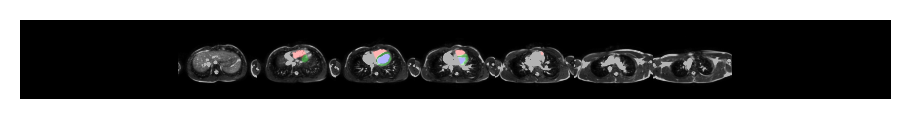

2020-12-21 10:49:44,013 INFO GT on AX


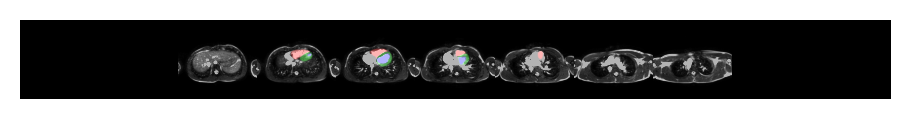

2020-12-21 10:49:44,524 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-21 10:49:44,532 INFO DICE LV: 0.8220198750495911
2020-12-21 10:49:44,540 INFO DICE RV: 0.722630500793457
2020-12-21 10:49:44,548 INFO DICE MYO: 0.7077488899230957
2020-12-21 10:49:44,549 INFO m: [[ 0.5933 -0.7666  0.2458 -0.806 ]
 [ 0.2842  0.4849  0.827  -0.9634]
 [-0.7534 -0.4207  0.5054  4.246 ]]
2020-12-21 10:49:44,550 INFO m_mod: [[ 0.5933 -0.7666  0.2458  0.782 ]
 [ 0.2842  0.4849  0.827  -0.2231]
 [-0.7534 -0.4207  0.5054  0.9893]]
2020-12-21 10:49:44,550 INFO m_scaled: [[ 0.5933 -0.7666  0.2458  3.129 ]
 [ 0.2842  0.4849  0.827  -0.8926]
 [-0.7534 -0.4207  0.5054  3.957 ]]
2020-12-21 10:49:44,551 INFO 0000-GYMP57R6_2006-12-18_ED_msk.nrrd
2020-12-21 10:49:50,264 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:50,389 INFO DICE LV: 0.90936678647995
2020-12-21 10:49:50,465 INFO DICE RV: 0.7990962862968445
2020-12-21 10:49:50,542 INFO DICE MYO: 0.7298315763473511
2020-12-21 10

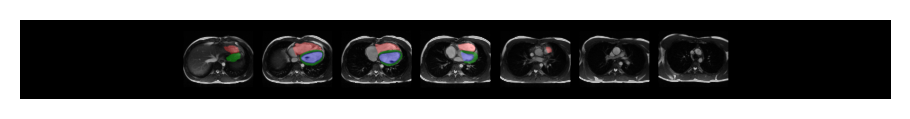

2020-12-21 10:49:51,527 INFO GT on AX


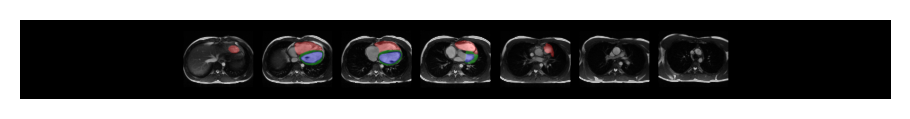

2020-12-21 10:49:51,994 INFO inv mask shape: (26, 156, 192, 4), gt mask shape: (26, 156, 192, 4)
2020-12-21 10:49:52,000 INFO DICE LV: 0.9237145781517029
2020-12-21 10:49:52,004 INFO DICE RV: 0.8079843521118164
2020-12-21 10:49:52,008 INFO DICE MYO: 0.7591497302055359
2020-12-21 10:49:52,009 INFO m: [[ 0.59   -0.771   0.2405 -0.8096]
 [ 0.285   0.4773  0.831  -0.9644]
 [-0.7554 -0.422   0.5015  4.293 ]]
2020-12-21 10:49:52,010 INFO m_mod: [[ 0.59   -0.771   0.2405  0.791 ]
 [ 0.285   0.4773  0.831  -0.2256]
 [-0.7554 -0.422   0.5015  1.    ]]
2020-12-21 10:49:52,010 INFO m_scaled: [[ 0.59   -0.771   0.2405  3.164 ]
 [ 0.285   0.4773  0.831  -0.9023]
 [-0.7554 -0.422   0.5015  4.    ]]
2020-12-21 10:49:52,011 INFO 0000-GYMP57R6_2006-12-18_ES_msk.nrrd
2020-12-21 10:49:57,687 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:49:57,815 INFO DICE LV: 0.8824852108955383
2020-12-21 10:49:57,892 INFO DICE RV: 0.6819201707839966
2020-12-21 10:49:57,969 INFO DICE MYO: 0.7722181677818298
2020-12-21

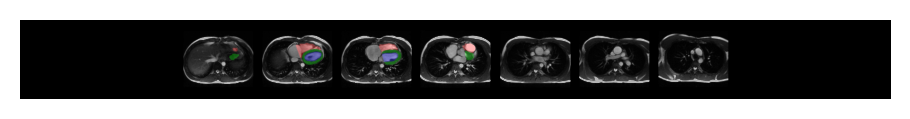

2020-12-21 10:49:58,950 INFO GT on AX


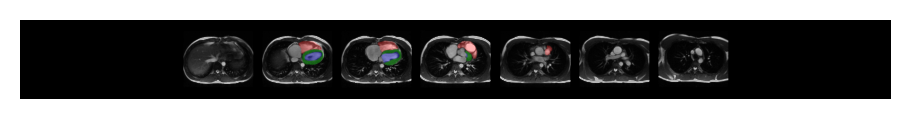

2020-12-21 10:49:59,421 INFO inv mask shape: (26, 156, 192, 4), gt mask shape: (26, 156, 192, 4)
2020-12-21 10:49:59,426 INFO DICE LV: 0.894332230091095
2020-12-21 10:49:59,430 INFO DICE RV: 0.7021347284317017
2020-12-21 10:49:59,434 INFO DICE MYO: 0.7913148999214172
2020-12-21 10:49:59,435 INFO m: [[ 0.5938 -0.765   0.2487 -0.8057]
 [ 0.2837  0.4885  0.825  -0.963 ]
 [-0.753  -0.4194  0.5073  4.24  ]]
2020-12-21 10:49:59,435 INFO m_mod: [[ 0.5938 -0.765   0.2487  0.781 ]
 [ 0.2837  0.4885  0.825  -0.2231]
 [-0.753  -0.4194  0.5073  0.9873]]
2020-12-21 10:49:59,435 INFO m_scaled: [[ 0.5938 -0.765   0.2487  3.123 ]
 [ 0.2837  0.4885  0.825  -0.8926]
 [-0.753  -0.4194  0.5073  3.95  ]]
2020-12-21 10:49:59,436 INFO 0000-GYRF6ZAA_2004-08-01_ED_msk.nrrd
2020-12-21 10:50:03,994 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:04,126 INFO DICE LV: 0.8958529829978943
2020-12-21 10:50:04,207 INFO DICE RV: 0.8026902079582214
2020-12-21 10:50:04,288 INFO DICE MYO: 0.6301832795143127
2020-12-21 

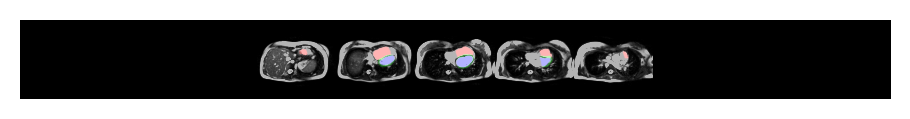

2020-12-21 10:50:05,266 INFO GT on AX


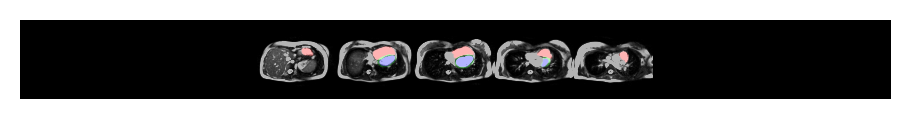

2020-12-21 10:50:05,727 INFO inv mask shape: (12, 256, 256, 4), gt mask shape: (12, 256, 256, 4)
2020-12-21 10:50:05,732 INFO DICE LV: 0.9162564873695374
2020-12-21 10:50:05,736 INFO DICE RV: 0.808172881603241
2020-12-21 10:50:05,740 INFO DICE MYO: 0.6551592350006104
2020-12-21 10:50:05,740 INFO m: [[ 0.5967 -0.7603  0.2563 -0.8022]
 [ 0.2825  0.4978  0.82   -0.962 ]
 [-0.751  -0.4167  0.5117  4.195 ]]
2020-12-21 10:50:05,741 INFO m_mod: [[ 0.5967 -0.7603  0.2563  0.773 ]
 [ 0.2825  0.4978  0.82   -0.2212]
 [-0.751  -0.4167  0.5117  0.978 ]]
2020-12-21 10:50:05,741 INFO m_scaled: [[ 0.5967 -0.7603  0.2563  3.092 ]
 [ 0.2825  0.4978  0.82   -0.885 ]
 [-0.751  -0.4167  0.5117  3.912 ]]
2020-12-21 10:50:05,742 INFO 0000-GYRF6ZAA_2004-08-01_ES_msk.nrrd
2020-12-21 10:50:10,442 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:10,569 INFO DICE LV: 0.8263400197029114
2020-12-21 10:50:10,647 INFO DICE RV: 0.7614073157310486
2020-12-21 10:50:10,723 INFO DICE MYO: 0.7386048436164856
2020-12-21 

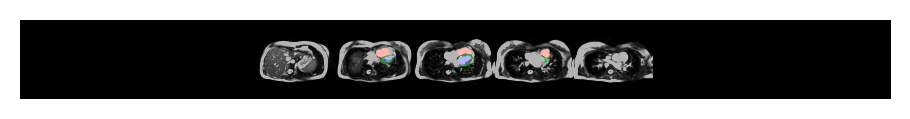

2020-12-21 10:50:11,699 INFO GT on AX


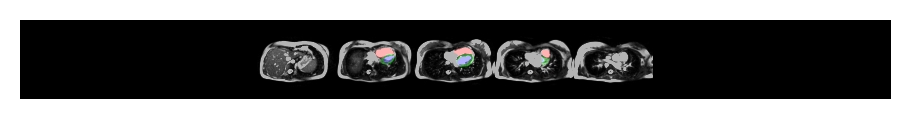

2020-12-21 10:50:12,168 INFO inv mask shape: (12, 256, 256, 4), gt mask shape: (12, 256, 256, 4)
2020-12-21 10:50:12,173 INFO DICE LV: 0.8440777063369751
2020-12-21 10:50:12,178 INFO DICE RV: 0.7799184322357178
2020-12-21 10:50:12,182 INFO DICE MYO: 0.77271568775177
2020-12-21 10:50:12,182 INFO m: [[ 0.5923 -0.7676  0.2451 -0.807 ]
 [ 0.2842  0.484   0.828  -0.964 ]
 [-0.754  -0.4207  0.5044  4.26  ]]
2020-12-21 10:50:12,183 INFO m_mod: [[ 0.5923 -0.7676  0.2451  0.785 ]
 [ 0.2842  0.484   0.828  -0.2246]
 [-0.754  -0.4207  0.5044  0.993 ]]
2020-12-21 10:50:12,183 INFO m_scaled: [[ 0.5923 -0.7676  0.2451  3.14  ]
 [ 0.2842  0.484   0.828  -0.8984]
 [-0.754  -0.4207  0.5044  3.973 ]]
2020-12-21 10:50:12,184 INFO 0000-JDRPF7F4_2006-02-28_ED_msk.nrrd
2020-12-21 10:50:16,763 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:16,907 INFO DICE LV: 0.7585272192955017
2020-12-21 10:50:16,983 INFO DICE RV: 0.3395703136920929
2020-12-21 10:50:17,061 INFO DICE MYO: 0.5778286457061768
2020-12-21 1

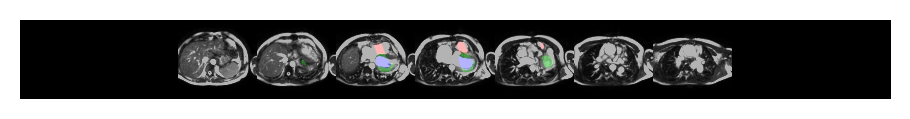

2020-12-21 10:50:18,055 INFO GT on AX


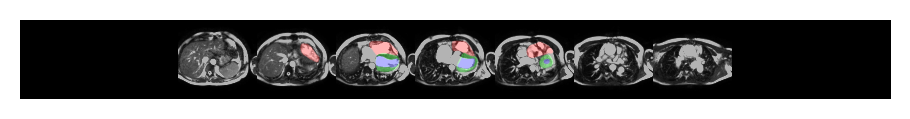

2020-12-21 10:50:18,567 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-21 10:50:18,575 INFO DICE LV: 0.7662720680236816
2020-12-21 10:50:18,583 INFO DICE RV: 0.3401055932044983
2020-12-21 10:50:18,591 INFO DICE MYO: 0.5902069807052612
2020-12-21 10:50:18,591 INFO m: [[ 0.5728 -0.796   0.1981 -0.8286]
 [ 0.2913  0.4233  0.8584 -0.971 ]
 [-0.766  -0.4338  0.474   4.57  ]]
2020-12-21 10:50:18,592 INFO m_mod: [[ 0.5728 -0.796   0.1981  0.8423]
 [ 0.2913  0.4233  0.8584 -0.2388]
 [-0.766  -0.4338  0.474   1.066 ]]
2020-12-21 10:50:18,592 INFO m_scaled: [[ 0.5728 -0.796   0.1981  3.37  ]
 [ 0.2913  0.4233  0.8584 -0.955 ]
 [-0.766  -0.4338  0.474   4.266 ]]
2020-12-21 10:50:18,593 INFO 0000-JDRPF7F4_2006-02-28_ES_msk.nrrd
2020-12-21 10:50:23,222 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:23,352 INFO DICE LV: 0.8771107196807861
2020-12-21 10:50:23,428 INFO DICE RV: 0.5283574461936951
2020-12-21 10:50:23,504 INFO DICE MYO: 0.6052157878875732
2020-12-21

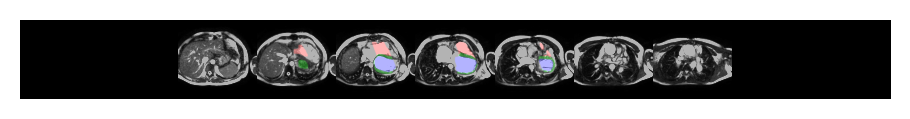

2020-12-21 10:50:24,531 INFO GT on AX


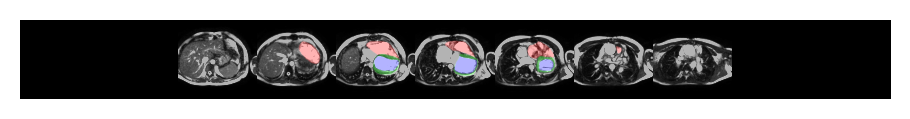

2020-12-21 10:50:25,042 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-21 10:50:25,050 INFO DICE LV: 0.8970522284507751
2020-12-21 10:50:25,058 INFO DICE RV: 0.5027180314064026
2020-12-21 10:50:25,066 INFO DICE MYO: 0.635086178779602
2020-12-21 10:50:25,066 INFO m: [[ 0.5796 -0.786   0.2153 -0.8213]
 [ 0.2888  0.445   0.8477 -0.9688]
 [-0.762  -0.429   0.4849  4.465 ]]
2020-12-21 10:50:25,067 INFO m_mod: [[ 0.5796 -0.786   0.2153  0.8223]
 [ 0.2888  0.445   0.8477 -0.2339]
 [-0.762  -0.429   0.4849  1.041 ]]
2020-12-21 10:50:25,067 INFO m_scaled: [[ 0.5796 -0.786   0.2153  3.29  ]
 [ 0.2888  0.445   0.8477 -0.9355]
 [-0.762  -0.429   0.4849  4.164 ]]
2020-12-21 10:50:25,068 INFO 0000-JP6XAZWH_2007-03-02_ED_msk.nrrd
2020-12-21 10:50:29,672 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:29,832 INFO DICE LV: 0.897223174571991
2020-12-21 10:50:29,921 INFO DICE RV: 0.7367318868637085
2020-12-21 10:50:30,032 INFO DICE MYO: 0.6458897590637207
2020-12-21 1

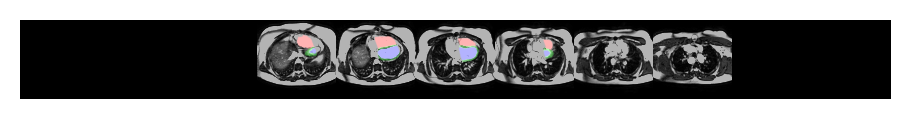

2020-12-21 10:50:31,005 INFO GT on AX


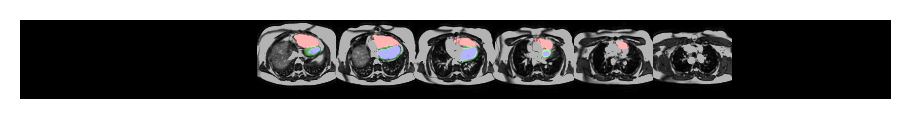

2020-12-21 10:50:31,502 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-21 10:50:31,510 INFO DICE LV: 0.9040117263793945
2020-12-21 10:50:31,517 INFO DICE RV: 0.7404680848121643
2020-12-21 10:50:31,525 INFO DICE MYO: 0.673260509967804
2020-12-21 10:50:31,526 INFO m: [[ 0.5894 -0.772   0.2391 -0.81  ]
 [ 0.2852  0.4756  0.8325 -0.965 ]
 [-0.756  -0.4224  0.5005  4.305 ]]
2020-12-21 10:50:31,526 INFO m_mod: [[ 0.5894 -0.772   0.2391  0.7925]
 [ 0.2852  0.4756  0.8325 -0.2266]
 [-0.756  -0.4224  0.5005  1.002 ]]
2020-12-21 10:50:31,527 INFO m_scaled: [[ 0.5894 -0.772   0.2391  3.17  ]
 [ 0.2852  0.4756  0.8325 -0.9062]
 [-0.756  -0.4224  0.5005  4.008 ]]
2020-12-21 10:50:31,527 INFO 0000-JP6XAZWH_2007-03-02_ES_msk.nrrd
2020-12-21 10:50:36,141 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:36,278 INFO DICE LV: 0.774482250213623
2020-12-21 10:50:36,361 INFO DICE RV: 0.5346930623054504
2020-12-21 10:50:36,446 INFO DICE MYO: 0.7300615906715393
2020-12-21 1

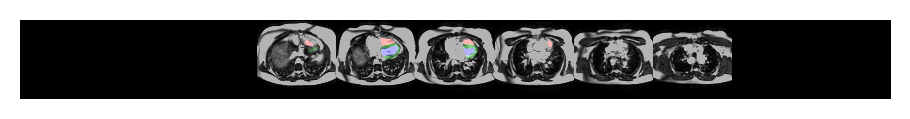

2020-12-21 10:50:37,419 INFO GT on AX


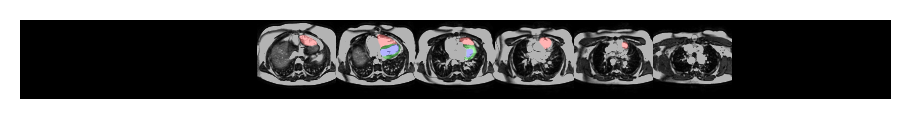

2020-12-21 10:50:37,918 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-21 10:50:37,926 INFO DICE LV: 0.7853337526321411
2020-12-21 10:50:37,933 INFO DICE RV: 0.5307621955871582
2020-12-21 10:50:37,939 INFO DICE MYO: 0.7503218054771423
2020-12-21 10:50:37,940 INFO m: [[ 0.584  -0.7803  0.2239 -0.817 ]
 [ 0.2874  0.4565  0.842  -0.9673]
 [-0.7593 -0.4272  0.491   4.395 ]]
2020-12-21 10:50:37,940 INFO m_mod: [[ 0.584  -0.7803  0.2239  0.8096]
 [ 0.2874  0.4565  0.842  -0.2305]
 [-0.7593 -0.4272  0.491   1.024 ]]
2020-12-21 10:50:37,941 INFO m_scaled: [[ 0.584  -0.7803  0.2239  3.238 ]
 [ 0.2874  0.4565  0.842  -0.922 ]
 [-0.7593 -0.4272  0.491   4.098 ]]
2020-12-21 10:50:37,941 INFO 0000-K4HCL72E_2007-03-27_ED_msk.nrrd
2020-12-21 10:50:42,477 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:42,612 INFO DICE LV: 0.9181976914405823
2020-12-21 10:50:42,693 INFO DICE RV: 0.804762601852417
2020-12-21 10:50:42,775 INFO DICE MYO: 0.6947335004806519
2020-12-21 

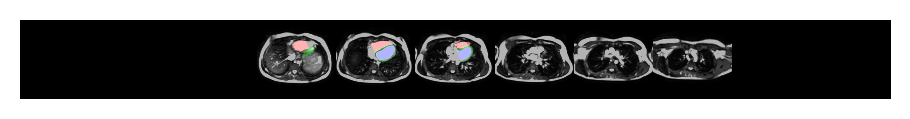

2020-12-21 10:50:43,780 INFO GT on AX


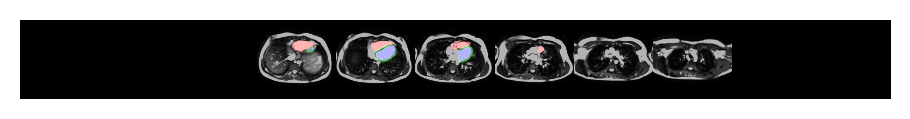

2020-12-21 10:50:44,271 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-21 10:50:44,278 INFO DICE LV: 0.9291883111000061
2020-12-21 10:50:44,285 INFO DICE RV: 0.8040972352027893
2020-12-21 10:50:44,292 INFO DICE MYO: 0.7322407960891724
2020-12-21 10:50:44,293 INFO m: [[ 0.5845 -0.779   0.2277 -0.8154]
 [ 0.287   0.461   0.84   -0.967 ]
 [-0.759  -0.4255  0.4934  4.375 ]]
2020-12-21 10:50:44,293 INFO m_mod: [[ 0.5845 -0.779   0.2277  0.8057]
 [ 0.287   0.461   0.84   -0.23  ]
 [-0.759  -0.4255  0.4934  1.02  ]]
2020-12-21 10:50:44,294 INFO m_scaled: [[ 0.5845 -0.779   0.2277  3.223 ]
 [ 0.287   0.461   0.84   -0.92  ]
 [-0.759  -0.4255  0.4934  4.08  ]]
2020-12-21 10:50:44,295 INFO 0000-K4HCL72E_2007-03-27_ES_msk.nrrd
2020-12-21 10:50:48,854 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:49,140 INFO DICE LV: 0.8756285905838013
2020-12-21 10:50:49,307 INFO DICE RV: 0.711203932762146
2020-12-21 10:50:49,398 INFO DICE MYO: 0.7693389654159546
2020-12-21 

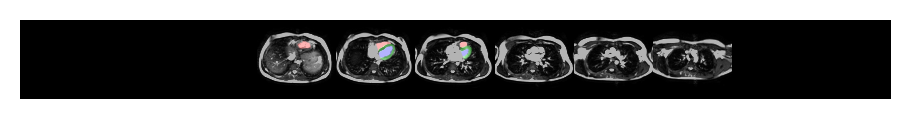

2020-12-21 10:50:50,413 INFO GT on AX


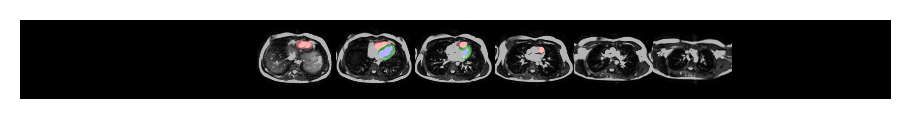

2020-12-21 10:50:50,980 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-21 10:50:50,987 INFO DICE LV: 0.8949171304702759
2020-12-21 10:50:50,993 INFO DICE RV: 0.7078226208686829
2020-12-21 10:50:51,000 INFO DICE MYO: 0.7892565131187439
2020-12-21 10:50:51,001 INFO m: [[ 0.593  -0.7666  0.2465 -0.806 ]
 [ 0.284   0.4856  0.8267 -0.9634]
 [-0.7534 -0.4202  0.5054  4.25  ]]
2020-12-21 10:50:51,002 INFO m_mod: [[ 0.593  -0.7666  0.2465  0.782 ]
 [ 0.284   0.4856  0.8267 -0.2236]
 [-0.7534 -0.4202  0.5054  0.9897]]
2020-12-21 10:50:51,002 INFO m_scaled: [[ 0.593  -0.7666  0.2465  3.129 ]
 [ 0.284   0.4856  0.8267 -0.8945]
 [-0.7534 -0.4202  0.5054  3.959 ]]
2020-12-21 10:50:51,003 INFO 0000-K61NJJ2D_2007-05-29_ED_msk.nrrd
2020-12-21 10:50:55,587 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:50:55,748 INFO DICE LV: 0.8715533018112183
2020-12-21 10:50:55,869 INFO DICE RV: 0.7739948034286499
2020-12-21 10:50:55,960 INFO DICE MYO: 0.5364709496498108
2020-12-21

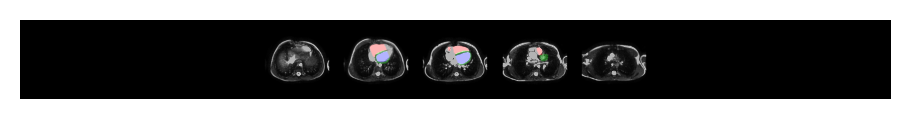

2020-12-21 10:50:56,953 INFO GT on AX


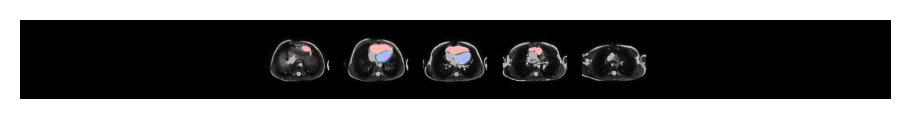

2020-12-21 10:50:58,818 INFO inv mask shape: (19, 288, 288, 4), gt mask shape: (19, 288, 288, 4)
2020-12-21 10:50:58,826 INFO DICE LV: 0.8854668736457825
2020-12-21 10:50:58,832 INFO DICE RV: 0.7795165777206421
2020-12-21 10:50:58,840 INFO DICE MYO: 0.556779682636261
2020-12-21 10:50:58,841 INFO m: [[ 0.574  -0.7944  0.1979 -0.827 ]
 [ 0.2908  0.424   0.8574 -0.9707]
 [-0.765  -0.4348  0.4746  4.54  ]]
2020-12-21 10:50:58,841 INFO m_mod: [[ 0.574  -0.7944  0.1979  0.836 ]
 [ 0.2908  0.424   0.8574 -0.2368]
 [-0.765  -0.4348  0.4746  1.057 ]]
2020-12-21 10:50:58,842 INFO m_scaled: [[ 0.574  -0.7944  0.1979  3.344 ]
 [ 0.2908  0.424   0.8574 -0.9473]
 [-0.765  -0.4348  0.4746  4.227 ]]
2020-12-21 10:50:58,845 INFO 0000-K61NJJ2D_2007-05-29_ES_msk.nrrd
2020-12-21 10:51:03,542 INFO shape: (1, 160, 224, 224, 3)
2020-12-21 10:51:03,674 INFO DICE LV: 0.6592299342155457
2020-12-21 10:51:03,758 INFO DICE RV: 0.23670653998851776
2020-12-21 10:51:03,842 INFO DICE MYO: 0.4877972900867462
2020-12-21

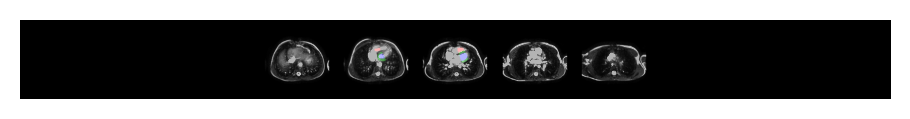

2020-12-21 10:51:04,806 INFO GT on AX


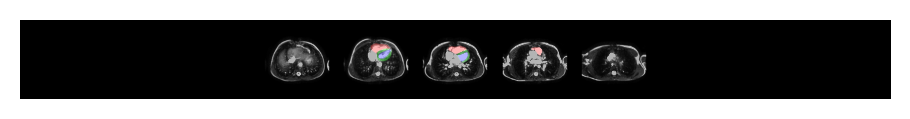

2020-12-21 10:51:05,286 INFO inv mask shape: (19, 288, 288, 4), gt mask shape: (19, 288, 288, 4)
2020-12-21 10:51:05,293 INFO DICE LV: 0.6838493347167969
2020-12-21 10:51:05,300 INFO DICE RV: 0.21877332031726837
2020-12-21 10:51:05,306 INFO DICE MYO: 0.5190699696540833
2020-12-21 10:51:05,307 INFO m: [[ 0.5747 -0.794   0.2006 -0.826 ]
 [ 0.2905  0.4268  0.857  -0.9707]
 [-0.765  -0.4343  0.4758  4.53  ]]
2020-12-21 10:51:05,307 INFO m_mod: [[ 0.5747 -0.794   0.2006  0.8345]
 [ 0.2905  0.4268  0.857  -0.2363]
 [-0.765  -0.4343  0.4758  1.056 ]]
2020-12-21 10:51:05,308 INFO m_scaled: [[ 0.5747 -0.794   0.2006  3.338 ]
 [ 0.2905  0.4268  0.857  -0.9453]
 [-0.765  -0.4343  0.4758  4.223 ]]


In [23]:
# predict on all test images, once with postprocessing, and once without
experiment_identifier = config['EXPERIMENT'].replace('/', '_') + 'orig_but_down_num100'
export_path = 'data/predicted/{}/3D/'.format(experiment_identifier)
use_modified_translation =  FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
slice_n = 5
debug = False
save = True
postprocess = True
logging.info('Use modified translation to scale: {}'.format(use_modified_translation))

# make predictions with different parameters in the same flow
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,
                           slice_n=slice_n, 
                           debug=debug,
                           export_path=export_path,
                           save=save,
                           postprocess=postprocess,
                           use_mod_translation=use_modified_translation)

# Further tests, where do our model fail, do we over- or under-segment

In [14]:
print(temp_ax.shape)
print(temp_pred.shape)
print(temp_gt.shape)

(14, 512, 512)
(14, 512, 512, 4)
(14, 512, 512, 4)


0.13646595776081133


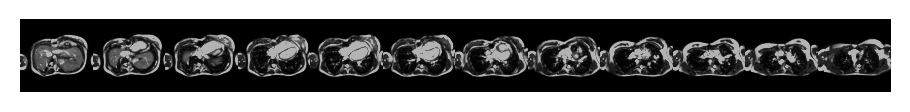

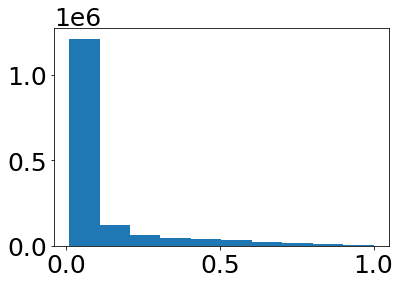

In [25]:
temp = temp_ax[:]
lower = np.quantile(temp.flatten(),.8)
print(lower)
temp = np.clip(temp, 0.01, 1)
show_2D_or_3D(temp)
plt.show()
plt.hist(temp.flatten())
plt.show()

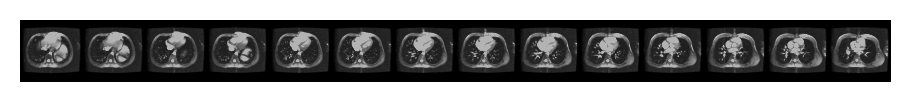

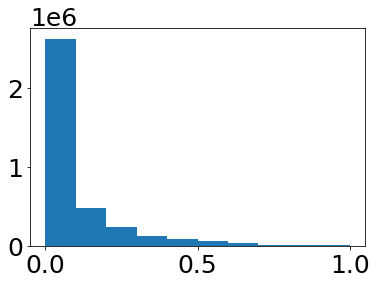

In [15]:
# did we clip the quantiles correctely, does the histogram match the raw data?
from src.data.Preprocess import clip_quantile
temp = temp_ax[:]

show_2D_or_3D(temp)
plt.show()
plt.hist(temp.flatten())
plt.show()


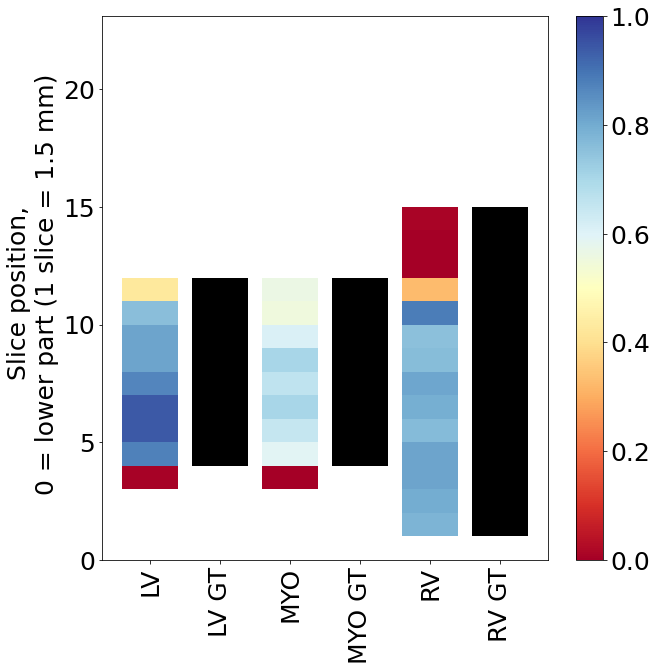

In [23]:
from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
plot_dice_per_slice_bar(temp_gt[...,1:],temp_pred[...,1:])